In [1]:
# =====================================================================
# IMPORT REQUIRED LIBRARIES
# =====================================================================
import os
import sys
import time
import json
import pickle
import queue
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from collections import defaultdict

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Computer Vision
import cv2
from PIL import Image

# System utilities
import psutil
import humanize
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All required libraries imported successfully!")
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"📦 NumPy version: {np.__version__}")



# =====================================================================
# BLOCK 2: LOAD AND PREPARE FULL CULANE DATASET
# =====================================================================
print("\n📂 LOADING COMPLETE CULANE DATASET")

BASE_PATH = "/kaggle/input/culane-preprocessed/temp"
IMAGE_FOLDER = os.path.join(BASE_PATH, "frames")
MASK_FOLDER = os.path.join(BASE_PATH, "masks")

print(f"📁 Dataset paths:")
print(f"  Images: {IMAGE_FOLDER}")
print(f"  Masks:  {MASK_FOLDER}")

if not os.path.exists(IMAGE_FOLDER):
    print(f"❌ ERROR: Image folder not found: {IMAGE_FOLDER}")
    exit()
if not os.path.exists(MASK_FOLDER):
    print(f"❌ ERROR: Mask folder not found: {MASK_FOLDER}")
    exit()

all_image_files = sorted(os.listdir(IMAGE_FOLDER))
all_mask_files = sorted(os.listdir(MASK_FOLDER))

print(f"\n📊 Found:")
print(f"  Images: {len(all_image_files):,}")
print(f"  Masks:  {len(all_mask_files):,}")

sample_img = os.path.join(IMAGE_FOLDER, all_image_files[0])
sample_size_kb = os.path.getsize(sample_img) / 1024
print(f"\n📏 Sample image size: {sample_size_kb:.1f} KB")

print("\n🔍 Matching ALL image-mask pairs...")

image_map = {os.path.splitext(f)[0]: f for f in all_image_files}
mask_map = {os.path.splitext(f)[0]: f for f in all_mask_files}

common_keys = sorted(set(image_map.keys()) & set(mask_map.keys()))
print(f"✅ Matched ALL {len(common_keys):,} image-mask pairs")

images = [image_map[k] for k in common_keys]
masks = [mask_map[k] for k in common_keys]

print(f"\n📦 Using COMPLETE dataset: {len(images):,} image-mask pairs")

IMG_SIZE = (224, 224)
print(f"\n📐 Image size set to: {IMG_SIZE}")

print(f"\n🎯 Splitting dataset...")

train_images, temp_images, train_masks, temp_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.333, random_state=42
)

print(f"\n📊 Final dataset split:")
print(f"  Training:   {len(train_images):,} images ({len(train_images)/len(images)*100:.1f}%)")
print(f"  Validation: {len(val_images):,} images ({len(val_images)/len(images)*100:.1f}%)")
print(f"  Testing:    {len(test_images):,} images ({len(test_images)/len(images)*100:.1f}%)")
print(f"  Total:      {len(images):,} images")

print("\n✅ COMPLETE dataset loaded successfully!")

2026-02-07 05:32:57.995728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770442378.175035      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770442378.227740      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770442378.667339      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770442378.667378      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770442378.667380      55 computation_placer.cc:177] computation placer alr

✅ All required libraries imported successfully!
📦 TensorFlow version: 2.19.0
📦 NumPy version: 2.0.2

📂 LOADING COMPLETE CULANE DATASET
📁 Dataset paths:
  Images: /kaggle/input/culane-preprocessed/temp/frames
  Masks:  /kaggle/input/culane-preprocessed/temp/masks

📊 Found:
  Images: 120,000
  Masks:  120,000

📏 Sample image size: 38.8 KB

🔍 Matching ALL image-mask pairs...
✅ Matched ALL 120,000 image-mask pairs

📦 Using COMPLETE dataset: 120,000 image-mask pairs

📐 Image size set to: (224, 224)

🎯 Splitting dataset...

📊 Final dataset split:
  Training:   84,000 images (70.0%)
  Validation: 24,012 images (20.0%)
  Testing:    11,988 images (10.0%)
  Total:      120,000 images

✅ COMPLETE dataset loaded successfully!


In [10]:
# =====================================================================
# BLOCK 3: CREATE DATA PIPELINE FOR 1GB DATASET
# =====================================================================
print("\n" + "="*60)
print("🚀 CREATING DATA PIPELINE FOR 1GB DATASET")
print("="*60)

# Settings optimized for 1GB dataset
BATCH_SIZE = 16  # Smaller batch size for 1GB dataset
BUFFER_SIZE = 500  # Smaller shuffle buffer
PREFETCH_BUFFER = tf.data.AUTOTUNE

print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔀 Shuffle buffer: {BUFFER_SIZE}")

@tf.function
def load_image_mask(img_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

def make_dataset(image_list, mask_list, batch_size=BATCH_SIZE, shuffle=True, train=True):
    """Create optimized TensorFlow dataset for 1GB dataset"""
    # Create full paths
    img_paths = [os.path.join(IMAGE_FOLDER, f) for f in image_list]
    mask_paths = [os.path.join(MASK_FOLDER, f) for f in mask_list]
    
    # Convert to tensors
    img_paths_tensor = tf.constant(img_paths)
    mask_paths_tensor = tf.constant(mask_paths)
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((img_paths_tensor, mask_paths_tensor))
    
    # Parallelize loading
    ds = ds.map(
        lambda x, y: load_image_mask(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if shuffle and train:
        ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch and prefetch
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=PREFETCH_BUFFER)
    
    return ds

# Create datasets
print("🔄 Creating training dataset...")
train_dataset = make_dataset(train_images, train_masks, shuffle=True, train=True)

print("🔄 Creating validation dataset...")
val_dataset = make_dataset(val_images, val_masks, shuffle=False, train=False)

print("🔄 Creating test dataset...")
test_dataset = make_dataset(test_images, test_masks, shuffle=False, train=False)

# Test the pipeline
print("\n🧪 Testing pipeline...")
for images, masks in train_dataset.take(1):
    print(f"✅ Pipeline test successful!")
    print(f"   Batch shape - Images: {images.shape}, Masks: {masks.shape}")
    print(f"   Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   Mask range:  [{tf.reduce_min(masks):.3f}, {tf.reduce_max(masks):.3f}]")
    print(f"   Unique mask values: {tf.unique(tf.reshape(masks, [-1]))[0]}")

# Calculate steps per epoch
train_steps = max(1, len(train_images) // BATCH_SIZE)
val_steps = max(1, len(val_images) // BATCH_SIZE)
test_steps = max(1, len(test_images) // BATCH_SIZE)

print(f"\n📊 Dataset Statistics:")
print(f"  Training steps per epoch: {train_steps}")
print(f"  Validation steps: {val_steps}")
print(f"  Test steps: {test_steps}")

print("\n🎯 Data pipeline created successfully for 1GB dataset!")


🚀 CREATING DATA PIPELINE FOR 1GB DATASET
📦 Batch size: 16
🔀 Shuffle buffer: 500
🔄 Creating training dataset...
🔄 Creating validation dataset...
🔄 Creating test dataset...

🧪 Testing pipeline...
✅ Pipeline test successful!
   Batch shape - Images: (16, 224, 224, 3), Masks: (16, 224, 224, 1)
   Image range: [0.000, 1.000]
   Mask range:  [0.000, 1.000]
   Unique mask values: [0. 1.]

📊 Dataset Statistics:
  Training steps per epoch: 5250
  Validation steps: 1500
  Test steps: 749

🎯 Data pipeline created successfully for 1GB dataset!


In [3]:
# =====================================================================
# BLOCK 3: CREATE DATA PIPELINE
# =====================================================================
# This block creates TensorFlow data pipelines
print("\n🚀 CREATING DATA PIPELINE")

# Settings
BATCH_SIZE = 16  # Adjusted for 1GB dataset
print(f"📦 Batch size: {BATCH_SIZE}")

def load_image_mask(img_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

def make_dataset(image_list, mask_list, batch_size=16, shuffle=True):
    """Create TensorFlow dataset"""
    img_paths = [os.path.join(IMAGE_FOLDER, f) for f in image_list]
    mask_paths = [os.path.join(MASK_FOLDER, f) for f in mask_list]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(
        lambda x, y: load_image_mask(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_dataset = make_dataset(train_images, train_masks, BATCH_SIZE, True)
val_dataset = make_dataset(val_images, val_masks, BATCH_SIZE, False)
test_dataset = make_dataset(test_images, test_masks, BATCH_SIZE, False)

# Test the pipeline
for images, masks in train_dataset.take(1):
    print(f"✅ Pipeline test: Images {images.shape}, Masks {masks.shape}")
    print(f"   Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   Mask range:  [{tf.reduce_min(masks):.3f}, {tf.reduce_max(masks):.3f}]")

print("🎯 Data pipeline created successfully!")


🚀 CREATING DATA PIPELINE
📦 Batch size: 16
✅ Pipeline test: Images (16, 224, 224, 3), Masks (16, 224, 224, 1)
   Image range: [0.000, 1.000]
   Mask range:  [0.000, 1.000]
🎯 Data pipeline created successfully!


In [4]:
# =====================================================================
# BLOCK 4: BUILD VGG16 U-NET MODEL
# =====================================================================
# This block creates the lane detection model
print("\n🏗️ BUILDING VGG16 U-NET MODEL")

# Clear any previous models
tf.keras.backend.clear_session()

def VGG16_UNet(input_shape=(224, 224, 3)):
    """Create VGG16-based U-Net model"""
    base = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Skip connections
    s1 = base.get_layer("block1_conv2").output
    s2 = base.get_layer("block2_conv2").output
    s3 = base.get_layer("block3_conv3").output
    s4 = base.get_layer("block4_conv3").output
    b  = base.get_layer("block5_conv3").output

    # Decoder
    d1 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(b), s4])
    d1 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(d1)

    d2 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d1), s3])
    d2 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(d2)

    d3 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d2), s2])
    d3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(d3)

    d4 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d3), s1])
    d4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(d4)

    # Output
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return tf.keras.Model(inputs=base.input, outputs=outputs)

# Create the model
model = VGG16_UNet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Display model info
print(f"\n📊 MODEL SUMMARY:")
print(f"Input shape:  {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Parameters:   {model.count_params():,}")
print(f"Model memory: {(model.count_params() * 4) / (1024**2):.2f} MB")

print("✅ Model built successfully!")


🏗️ BUILDING VGG16 U-NET MODEL
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

📊 MODEL SUMMARY:
Input shape:  (None, 224, 224, 3)
Output shape: (None, 224, 224, 1)
Parameters:   21,756,737
Model memory: 83.00 MB
✅ Model built successfully!


In [5]:
# =====================================================================
# BLOCK 5: DEFINE LOSS FUNCTIONS AND METRICS
# =====================================================================
# This block defines custom loss functions for lane detection
print("\n📊 DEFINING LOSS FUNCTIONS AND METRICS")

def dice_coef(y_true, y_pred):
    """Dice coefficient metric"""
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1)

def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined Binary Cross-Entropy + Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Also define for PBFT compatibility
dice_coefficient = dice_coef  # Alias for PBFT

print("✅ Loss functions defined: Dice Coefficient, BCE+Dice Loss")


📊 DEFINING LOSS FUNCTIONS AND METRICS
✅ Loss functions defined: Dice Coefficient, BCE+Dice Loss


In [6]:
# =====================================================================
# BLOCK 6: COMPILE AND TRAIN THE MODEL
# =====================================================================
# This block compiles and trains the model
print("\n🚀 STARTING MODEL TRAINING")

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, 'binary_accuracy']
)
print("✅ Model compiled with Adam optimizer (lr=1e-4)")

# Setup training callbacks
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_lane_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Log training history
    tf.keras.callbacks.CSVLogger('training_log.csv')
]

print(f"\n📊 TRAINING CONFIGURATION:")
print(f"  Training images:   {len(train_images):,}")
print(f"  Validation images: {len(val_images):,}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Steps per epoch:   ~{len(train_images) // BATCH_SIZE}")

# Memory check
print(f"\n🧠 Memory before training: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")

# Train for 3 epochs (quick training for 1GB dataset)
print("\n" + "="*60)
print("PHASE 1: INITIAL TRAINING (3 EPOCHS)")
print("="*60)

try:
    # Train for 3 epochs
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=min(100, len(train_images) // BATCH_SIZE),
        validation_steps=min(20, len(val_images) // BATCH_SIZE)
    )
    
    print(f"\n🧠 Memory after 3 epochs: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")
    
    # Continue training for 2 more epochs if memory is OK
    print("\n" + "="*60)
    print("PHASE 2: ADDITIONAL TRAINING (2 MORE EPOCHS)")
    print("="*60)
    
    history_phase2 = model.fit(
        train_dataset,
        validation_data=val_dataset,
        initial_epoch=3,
        epochs=4,
        callbacks=callbacks,
        verbose=1
    )
    
    # Combine histories
    full_history = {}
    for metric in history.history.keys():
        if metric in history_phase2.history:
            full_history[metric] = history.history[metric] + history_phase2.history[metric]
        else:
            full_history[metric] = history.history[metric]
    
    print("\n🎉 Training completed successfully!")
    
except MemoryError as e:
    print(f"\n⚠️ Memory error: {e}")
    print("Using limited training...")
    
    # Simple training with limited steps
    full_history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=min(50, len(train_images) // BATCH_SIZE),
        validation_steps=min(10, len(val_images) // BATCH_SIZE)
    ).history

# Save final model
model.save('final_lane_model.keras')
print("\n💾 Final model saved as 'final_lane_model.keras'")

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(full_history, f)
print("📝 Training history saved as 'training_history.pkl'")

print(f"\n🧠 Final memory: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")


🚀 STARTING MODEL TRAINING
✅ Model compiled with Adam optimizer (lr=1e-4)

📊 TRAINING CONFIGURATION:
  Training images:   84,000
  Validation images: 24,012
  Batch size:        16
  Steps per epoch:   ~5250

🧠 Memory before training: 1.8 GB

PHASE 1: INITIAL TRAINING (3 EPOCHS)
Epoch 1/3


I0000 00:00:1770442414.835339     140 service.cc:152] XLA service 0x7dfebc0033d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770442414.835379     140 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770442415.883385     140 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770442445.417537     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - binary_accuracy: 0.9614 - dice_coef: 0.2094 - loss: 0.9544
Epoch 1: val_loss improved from inf to 0.64837, saving model to best_lane_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 412ms/step - binary_accuracy: 0.9615 - dice_coef: 0.2106 - loss: 0.9528 - val_binary_accuracy: 0.9722 - val_dice_coef: 0.4457 - val_loss: 0.6484 - learning_rate: 1.0000e-04
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9717 - dice_coef: 0.4584 - loss: 0.6367
Epoch 2: val_loss improved from 0.64837 to 0.59692, saving model to best_lane_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - binary_accuracy: 0.9717 - dice_coef: 0.4584 - loss: 0.6367 - val_binary_accuracy: 0.9760 - val_dice_coef: 0.4935 - val_loss: 0.5969 - learning_rate: 1.0000e-04
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - binary_accuracy: 0.9736 - dice_coef: 0.4862 - loss: 0.6037
Epoch 3: val_loss improved from 0.59692 to 0.57433, saving model to best_lane_mo

2026-02-07 06:01:15.590964: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:01:15.839524: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 4: val_loss improved from 0.57433 to 0.41364, saving model to best_lane_model.keras
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 1534s 292ms/step - binary_accuracy: 0.9783 - dice_coef: 0.5831 - loss: 0.4901 - val_binary_accuracy: 0.9821 - val_dice_coef: 0.6479 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.

🎉 Training completed successfully!

💾 Final model saved as 'final_lane_model.keras'
📝 Training history saved as 'training_history.pkl'

🧠 Final memory: 4.5 GB



📊 EVALUATING MODEL PERFORMANCE
✅ Loaded best model for evaluation

🔍 Testing model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - dice_coef: 0.6595 - loss: 0.3994

📈 TEST RESULTS:
  dice_coef: 0.6550
  loss: 0.4055

📊 Calculating pixel-wise metrics...

DETAILED METRICS
Accuracy:       0.9830
Precision:      0.6976
Recall:         0.6787
F1-Score:       0.6880
IoU:            0.5244
Dice:           0.6550
Test Loss:      0.4055
Total pixels:   8,028,160
Lane pixels:    221,629 (2.76%)

💾 Metrics saved to 'evaluation_metrics.json'

📈 Plotting training history...


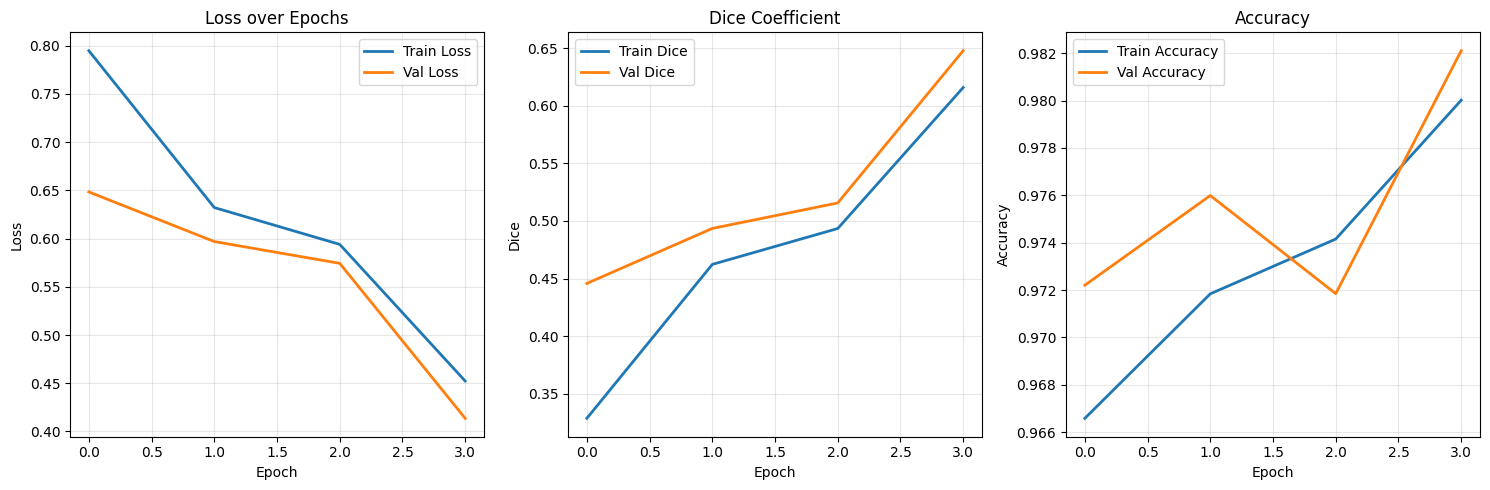

✅ Training plots saved as 'training_history_plot.png'


In [7]:
# =====================================================================
# BLOCK 7: EVALUATE MODEL PERFORMANCE
# =====================================================================
# This block evaluates the trained model
print("\n📊 EVALUATING MODEL PERFORMANCE")

# Load best model for evaluation
try:
    model = tf.keras.models.load_model(
        'best_lane_model.keras',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_loss': dice_loss,
            'bce_dice_loss': bce_dice_loss
        },
        compile=False
    )
    print("✅ Loaded best model for evaluation")
except:
    model = tf.keras.models.load_model('final_lane_model.keras', compile=False)
    print("✅ Loaded final model for evaluation")

# Recompile for evaluation
model.compile(loss=bce_dice_loss, metrics=[dice_coef])

# Evaluate on test set
print("\n🔍 Testing model on test set...")
test_results = model.evaluate(
    test_dataset, 
    verbose=1, 
    steps=min(20, len(test_images) // BATCH_SIZE), 
    return_dict=True
)

print(f"\n📈 TEST RESULTS:")
for metric, value in test_results.items():
    print(f"  {metric}: {value:.4f}")

# Calculate detailed metrics
print("\n📊 Calculating pixel-wise metrics...")
y_true_list, y_pred_list = [], []

for images, masks in test_dataset.take(10):  # Use 10 batches
    preds = model.predict(images, verbose=0)
    y_true_list.append(masks.numpy().astype(np.uint8).reshape(-1))
    y_pred_list.append((preds > 0.5).astype(np.uint8).reshape(-1))

if y_true_list:
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union > 0 else 0
    
    print("\n" + "="*50)
    print("DETAILED METRICS")
    print("="*50)
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"IoU:            {iou:.4f}")
    print(f"Dice:           {test_results.get('dice_coef', 0):.4f}")
    print(f"Test Loss:      {test_results.get('loss', 0):.4f}")
    print(f"Total pixels:   {len(y_true):,}")
    print(f"Lane pixels:    {np.sum(y_true):,} ({np.mean(y_true)*100:.2f}%)")
    
    # Save metrics
    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'iou': float(iou),
        'dice': float(test_results.get('dice_coef', 0)),
        'test_loss': float(test_results.get('loss', 0))
    }
    
    with open('evaluation_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    print("\n💾 Metrics saved to 'evaluation_metrics.json'")

# Plot training history
print("\n📈 Plotting training history...")
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
if 'loss' in full_history:
    plt.plot(full_history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in full_history:
        plt.plot(full_history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Dice plot
plt.subplot(1, 3, 2)
if 'dice_coef' in full_history:
    plt.plot(full_history['dice_coef'], label='Train Dice', linewidth=2)
    if 'val_dice_coef' in full_history:
        plt.plot(full_history['val_dice_coef'], label='Val Dice', linewidth=2)
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 3)
if 'binary_accuracy' in full_history:
    plt.plot(full_history['binary_accuracy'], label='Train Accuracy', linewidth=2)
    if 'val_binary_accuracy' in full_history:
        plt.plot(full_history['val_binary_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Training plots saved as 'training_history_plot.png'")


🎨 VISUALIZING PREDICTIONS
  Sample 1: 864 lane pixels (1.72%)
  Sample 2: 1,567 lane pixels (3.12%)
  Sample 3: 1,538 lane pixels (3.07%)


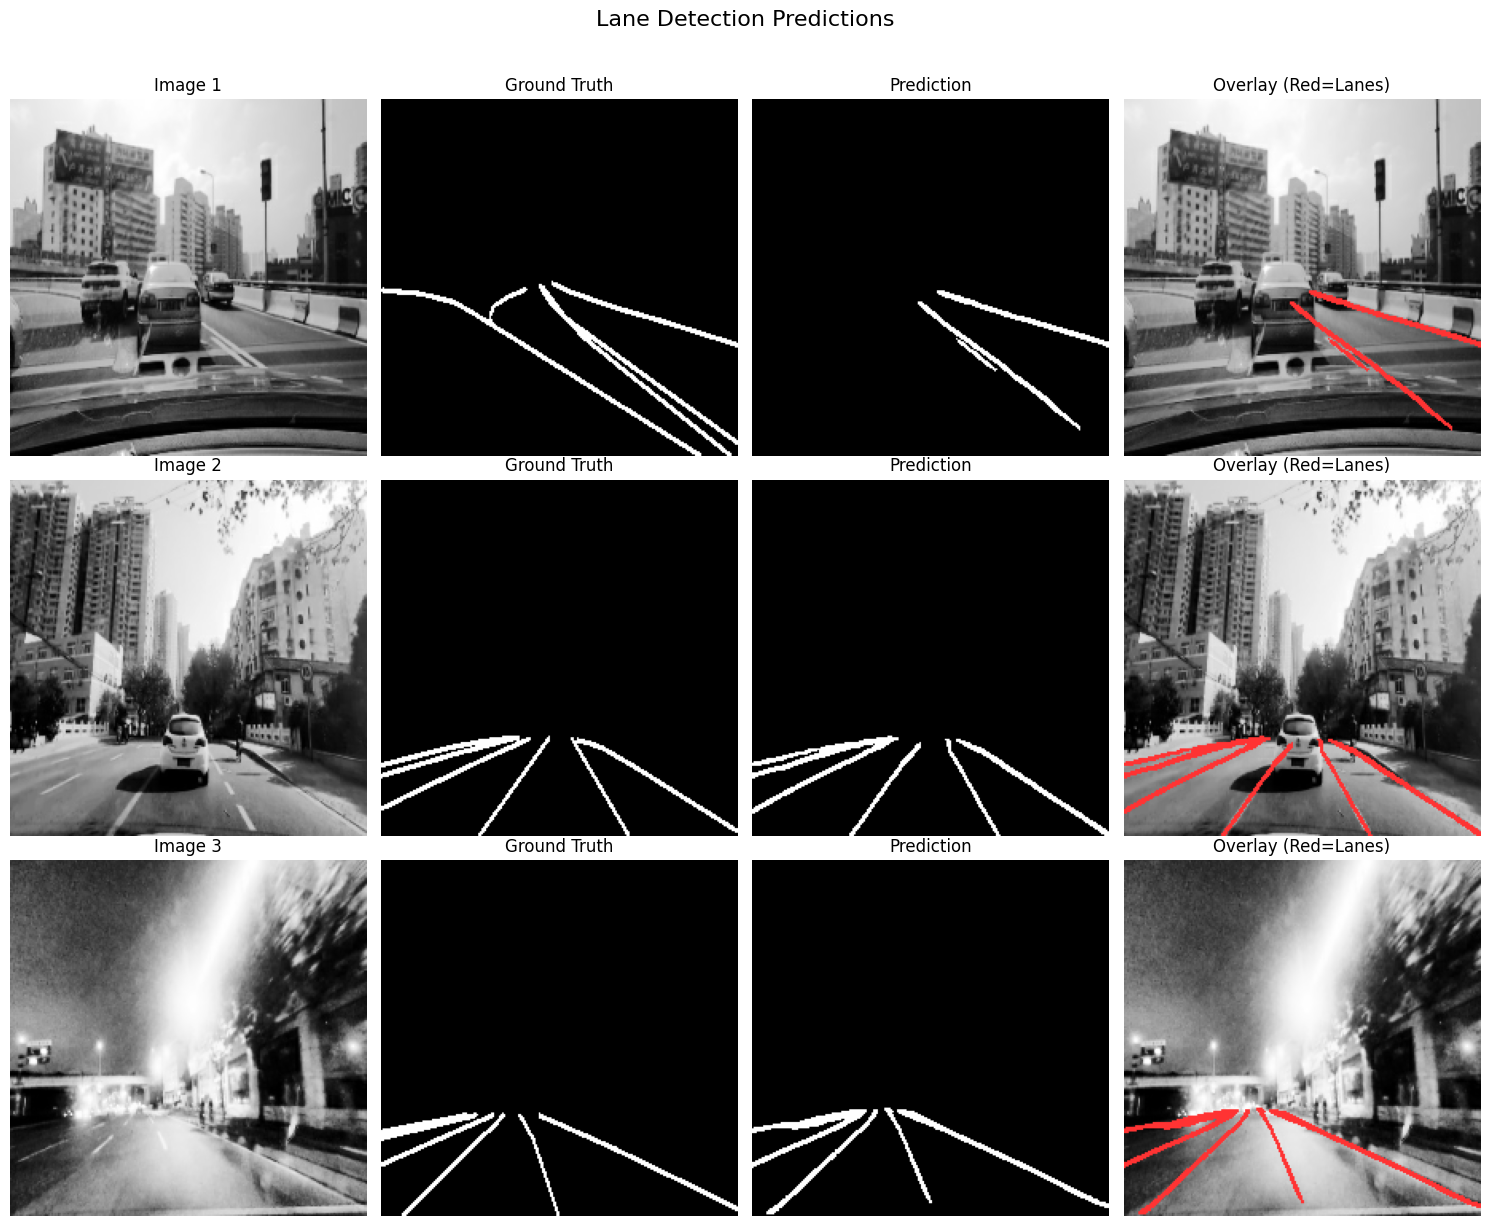

✅ Sample predictions saved as 'sample_predictions.png'


In [8]:
# =====================================================================
# BLOCK 8: VISUALIZE PREDICTIONS
# =====================================================================
# This block creates visualizations comparing predictions with ground truth
print("\n🎨 VISUALIZING PREDICTIONS")

def show_sample_predictions(num_samples=3):
    """Display side-by-side comparison of images, ground truth, and predictions"""
    plt.figure(figsize=(15, 4*num_samples))
    
    sample_count = 0
    for images, masks in test_dataset.take(2):
        if sample_count >= num_samples:
            break
            
        preds = model.predict(images, verbose=0)
        
        for i in range(min(num_samples, len(images))):
            if sample_count >= num_samples:
                break
                
            # Original image
            plt.subplot(num_samples, 4, sample_count*4 + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Image {sample_count+1}")
            plt.axis('off')
            
            # Ground truth mask
            plt.subplot(num_samples, 4, sample_count*4 + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')
            
            # Predicted mask
            plt.subplot(num_samples, 4, sample_count*4 + 3)
            plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
            plt.title("Prediction")
            plt.axis('off')
            
            # Overlay (red lanes on image)
            plt.subplot(num_samples, 4, sample_count*4 + 4)
            overlay = images[i].numpy().copy()
            pred_mask = (preds[i].squeeze() > 0.5)
            overlay[pred_mask] = [1, 0.2, 0.2]  # Red color for lanes
            plt.imshow(overlay)
            plt.title("Overlay (Red=Lanes)")
            plt.axis('off')
            
            # Print lane statistics
            lane_pixels = np.sum(preds[i].squeeze() > 0.5)
            total_pixels = preds[i].size
            lane_percentage = (lane_pixels / total_pixels) * 100
            print(f"  Sample {sample_count+1}: {lane_pixels:,} lane pixels ({lane_percentage:.2f}%)")
            
            sample_count += 1
    
    plt.suptitle("Lane Detection Predictions", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Generate and save predictions
show_sample_predictions(3)
print("✅ Sample predictions saved as 'sample_predictions.png'")

In [11]:
# =====================================================================
# BLOCK 1: SETUP AND IMPORTS
# =====================================================================
print("🔧 Setting up environment...")

import os
import sys
import time
import json
import pickle
import queue
import threading
import numpy as np
from copy import deepcopy
from collections import defaultdict
from sklearn.cluster import DBSCAN

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ BLOCK 1: Setup complete!")
print(f"📦 TensorFlow: {tf.__version__}")
print(f"📦 NumPy: {np.__version__}")

🔧 Setting up environment...
✅ BLOCK 1: Setup complete!
📦 TensorFlow: 2.19.0
📦 NumPy: 2.0.2


In [25]:
# =====================================================================
# BLOCK 2: LOAD YOUR TRAINED LANE DETECTION MODEL
# =====================================================================
print("\n" + "="*60)
print("🤖 LOADING YOUR TRAINED LANE DETECTION MODEL")
print("="*60)

# Define the same loss functions used during training
def dice_coef(y_true, y_pred):
    """Dice coefficient metric"""
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1)

def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined Binary Cross-Entropy + Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Try to load the trained model
try:
    model = tf.keras.models.load_model(
        'final_lane_model.keras',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_loss': dice_loss,
            'bce_dice_loss': bce_dice_loss
        },
        compile=False
    )
    print("✅ SUCCESS: Loaded 'final_lane_model.keras'")
    print(f"   Model input shape: {model.input_shape}")
    print(f"   Model output shape: {model.output_shape}")
    
except FileNotFoundError:
    print("⚠️  'final_lane_model.keras' not found. Trying 'best_lane_model.keras'...")
    try:
        model = tf.keras.models.load_model(
            'best_lane_model.keras',
            custom_objects={
                'dice_coef': dice_coef,
                'dice_loss': dice_loss,
                'bce_dice_loss': bce_dice_loss
            },
            compile=False
        )
        print("✅ SUCCESS: Loaded 'best_lane_model.keras'")
    except Exception as e:
        print(f"❌ ERROR: Could not load any model. Error: {e}")
        model = None
        print("⚠️  Continuing with model=None. Please check your model files.")

# Model configuration based on your training
IMG_SIZE = (224, 224)  # Your model's input size
print(f"\n📐 Model configuration:")
print(f"   Input size: {IMG_SIZE}")
print(f"   Channels: RGB (3 channels)")

# Test the model with a dummy input if loaded
if model is not None:
    dummy_input = np.random.randn(1, IMG_SIZE[0], IMG_SIZE[1], 3).astype(np.float32)
    dummy_output = model.predict(dummy_input, verbose=0)
    print(f"   Test prediction shape: {dummy_output.shape}")
    print("✅ Model is ready for inference!")

print("\n✅ BLOCK 2: Model loading complete!")


🤖 LOADING YOUR TRAINED LANE DETECTION MODEL
✅ SUCCESS: Loaded 'final_lane_model.keras'
   Model input shape: (None, 224, 224, 3)
   Model output shape: (None, 224, 224, 1)

📐 Model configuration:
   Input size: (224, 224)
   Channels: RGB (3 channels)
   Test prediction shape: (1, 224, 224, 1)
✅ Model is ready for inference!

✅ BLOCK 2: Model loading complete!



📸 LOADING TEST IMAGES
📁 Found 120,000 images in /kaggle/input/culane-preprocessed/temp/frames
📊 Will process 10 sample images

📏 Sample image:
   Name: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Size: (320, 256)
   Mode: L
   Preview:


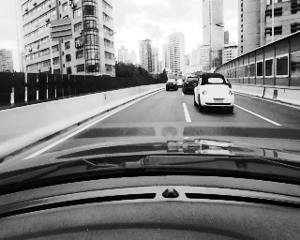


✅ BLOCK 3: Test images loaded!


In [26]:
# =====================================================================
# BLOCK 3: LOAD TEST IMAGES FOR PROCESSING
# =====================================================================
print("\n" + "="*60)
print("📸 LOADING TEST IMAGES")
print("="*60)

# Configuration
TEST_IMAGE_DIR = "/kaggle/input/culane-preprocessed/temp/frames"  # Your image directory
SAMPLE_IMAGES_COUNT = 10  # How many images to process

# List available images
if os.path.exists(TEST_IMAGE_DIR):
    all_images = sorted([f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"📁 Found {len(all_images):,} images in {TEST_IMAGE_DIR}")
    
    # Take a sample of images for processing
    if len(all_images) > SAMPLE_IMAGES_COUNT:
        sample_indices = np.linspace(0, len(all_images)-1, SAMPLE_IMAGES_COUNT, dtype=int)
        test_images = [all_images[i] for i in sample_indices]
    else:
        test_images = all_images
    
    print(f"📊 Will process {len(test_images)} sample images")
    
    # Display sample image info
    if test_images:
        sample_path = os.path.join(TEST_IMAGE_DIR, test_images[0])
        sample_img = Image.open(sample_path)
        print(f"\n📏 Sample image:")
        print(f"   Name: {test_images[0]}")
        print(f"   Size: {sample_img.size}")
        print(f"   Mode: {sample_img.mode}")
        sample_img.thumbnail((300, 300))
        print("   Preview:")
        display(sample_img)
else:
    print(f"❌ WARNING: Test image directory not found: {TEST_IMAGE_DIR}")
    print("Using synthetic test images instead...")
    test_images = [f"test_{i}.jpg" for i in range(SAMPLE_IMAGES_COUNT)]

print("\n✅ BLOCK 3: Test images loaded!")

In [48]:
# =====================================================================
# BLOCK 4: LANE DETECTION FUNCTION FOR SINGLE IMAGE (CORRECTED VERSION)
# =====================================================================
print("\n" + "="*60)
print("🔍 LANE DETECTION FUNCTION (CORRECTED)")
print("="*60)

def detect_lanes_in_image(image_path, model, cluster_eps=15.0, min_samples=10):
    """
    Process a single image for lane detection using your trained model
    
    Args:
        image_path: Path to the image file
        model: Loaded TensorFlow model
        cluster_eps: DBSCAN epsilon parameter - INCREASED for lane detection
        min_samples: DBSCAN minimum samples - DECREASED for fragmented lanes
    """
    if model is None:
        print("❌ Model not loaded!")
        return None
    
    try:
        # Start timing
        start_time = time.time()
        
        # --- 1. Load and preprocess image ---
        print(f"\n📥 Loading image: {os.path.basename(image_path)}")
        
        # Load image using PIL
        pil_img = Image.open(image_path)
        
        # Convert to RGB if needed
        if pil_img.mode != 'RGB':
            pil_img = pil_img.convert('RGB')
        
        # Convert to numpy array
        original_img = np.array(pil_img)
        
        print(f"   Original size: {original_img.shape[1]}x{original_img.shape[0]}")
        print(f"   Original channels: {original_img.shape[2]}")
        
        # --- 2. Resize to model input size ---
        resized_img = tf.image.resize(original_img, IMG_SIZE)
        resized_img = resized_img.numpy().astype(np.float32) / 255.0
        
        # Add batch dimension
        input_tensor = np.expand_dims(resized_img, axis=0)
        
        # --- 3. Model inference ---
        print("   Running model inference...")
        inference_start = time.time()
        prediction = model.predict(input_tensor, verbose=0)
        inference_time = time.time() - inference_start
        
        # Get binary mask
        binary_mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8)
        
        # --- 4. Analyze lane pixels ---
        # Count lane pixels
        total_pixels = binary_mask.size
        lane_pixels = np.sum(binary_mask)
        lane_percentage = (lane_pixels / total_pixels) * 100
        
        print(f"   Lane pixels: {lane_pixels:,}/{total_pixels:,} ({lane_percentage:.2f}%)")
        
        # --- 5. Lane counting with DBSCAN clustering (UPDATED PARAMETERS) ---
        num_lanes = 0
        lane_clusters = None
        
        if lane_pixels > 5:  # Even smaller threshold for testing
            # Get coordinates of lane pixels
            lane_coords = np.argwhere(binary_mask == 1)
            
            # Apply DBSCAN clustering with BETTER parameters
            print(f"   Clustering {len(lane_coords)} lane pixels...")
            print(f"   DBSCAN params: eps={cluster_eps}, min_samples={min_samples}")
            
            clusterer = DBSCAN(eps=cluster_eps, min_samples=min_samples)
            clusters = clusterer.fit(lane_coords)
            
            # Count clusters (excluding noise)
            unique_labels = np.unique(clusters.labels_)
            num_lanes = len(unique_labels[unique_labels != -1])  # Exclude noise
            
            # Store cluster information
            lane_clusters = []
            for label in unique_labels:
                if label != -1:  # Skip noise
                    cluster_points = lane_coords[clusters.labels_ == label]
                    lane_clusters.append({
                        'label': int(label),
                        'points_count': len(cluster_points),
                        'center': cluster_points.mean(axis=0).tolist(),
                        'min_y': cluster_points[:, 0].min(),
                        'max_y': cluster_points[:, 0].max()
                    })
            
            print(f"   Found {num_lanes} lane clusters")
            for i, cluster in enumerate(lane_clusters):
                print(f"     Lane {i+1}: {cluster['points_count']} pixels "
                      f"(y-range: {cluster['min_y']}-{cluster['max_y']})")
        else:
            print(f"   Not enough lane pixels for clustering ({lane_pixels} pixels)")
        
        # --- 6. Create visualization ---
        # Create overlay
        original_resized = tf.image.resize(original_img, IMG_SIZE).numpy().astype(np.uint8)
        overlay = original_resized.copy()
        
        if lane_pixels > 0:
            # Create colored mask for visualization
            colored_mask = np.zeros((*IMG_SIZE, 3), dtype=np.uint8)
            
            # Color different lanes differently if we have clusters
            if lane_clusters:
                colors = [
                    (255, 0, 0),    # Red - Lane 1
                    (0, 255, 0),    # Green - Lane 2
                    (0, 0, 255),    # Blue - Lane 3
                    (255, 255, 0),  # Yellow - Lane 4
                    (255, 0, 255),  # Magenta - Lane 5
                    (0, 255, 255),  # Cyan - Lane 6
                ]
                
                lane_coords = np.argwhere(binary_mask == 1)
                clusters = clusterer.fit(lane_coords)
                
                for label in np.unique(clusters.labels_):
                    if label != -1:
                        cluster_points = lane_coords[clusters.labels_ == label]
                        color = colors[label % len(colors)]
                        for y, x in cluster_points:
                            colored_mask[y, x] = color
            else:
                # Single color for all lanes
                colored_mask[binary_mask == 1] = (0, 255, 0)  # Green
            
            # Blend with original
            alpha = 0.6  # Transparency
            overlay = cv2.addWeighted(original_resized, 1 - alpha, colored_mask, alpha, 0)
        
        # --- 7. Total processing time ---
        total_time = time.time() - start_time
        
        # --- 8. Compile results ---
        results = {
            'image_name': os.path.basename(image_path),
            'image_size_original': original_img.shape[:2],
            'image_size_processed': IMG_SIZE,
            'detected_lane_pixels': int(lane_pixels),
            'total_pixels': int(total_pixels),
            'lane_percentage': float(lane_percentage),
            'lanes_detected': int(num_lanes),
            'inference_time': float(inference_time),
            'total_processing_time': float(total_time),
            'timestamp': time.time(),
            'binary_mask_shape': list(binary_mask.shape),
            'lane_clusters': lane_clusters if lane_clusters else [],
            'visualization': overlay,  # Keep for display
            'binary_mask': binary_mask,  # Keep for analysis
            'dbscan_params': {
                'eps': cluster_eps,
                'min_samples': min_samples
            }
        }
        
        print(f"✅ Detection complete in {total_time:.3f}s")
        print(f"   Results: {num_lanes} lanes, {lane_pixels:,} pixels")
        
        return results
        
    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        import traceback
        traceback.print_exc()
        return None

# Test the function with a sample image
if test_images and model is not None and os.path.exists(TEST_IMAGE_DIR):
    sample_image_path = os.path.join(TEST_IMAGE_DIR, test_images[0])
    print(f"\n🧪 Testing lane detection function with: {test_images[0]}")
    
    # Test with different DBSCAN parameters
    print("\n🔧 Testing different DBSCAN parameters:")
    
    # Test 1: Original (too strict)
    print("\n1. Strict parameters (eps=3.0, min_samples=30):")
    result1 = detect_lanes_in_image(sample_image_path, model, cluster_eps=3.0, min_samples=30)
    
    # Test 2: Better parameters for lanes
    print("\n2. Better parameters (eps=15.0, min_samples=10):")
    result2 = detect_lanes_in_image(sample_image_path, model, cluster_eps=15.0, min_samples=10)
    
    # Test 3: Even looser for fragmented lanes
    print("\n3. Loose parameters (eps=20.0, min_samples=5):")
    result3 = detect_lanes_in_image(sample_image_path, model, cluster_eps=20.0, min_samples=5)
    
    print(f"\n📊 COMPARISON RESULTS:")
    if result1: print(f"   Strict: {result1['lanes_detected']} lanes")
    if result2: print(f"   Better: {result2['lanes_detected']} lanes") 
    if result3: print(f"   Loose: {result3['lanes_detected']} lanes")
    
    # Use the best result for visualization
    best_result = result2 or result3 or result1
    if best_result:
        print(f"\n📊 Test Results Summary:")
        print(f"   Image: {best_result['image_name']}")
        print(f"   Lanes detected: {best_result['lanes_detected']}")
        print(f"   Lane pixels: {best_result['detected_lane_pixels']:,}")
        print(f"   Inference time: {best_result['inference_time']:.3f}s")

print("\n✅ BLOCK 4: Corrected lane detection function ready!")


🔍 LANE DETECTION FUNCTION (CORRECTED)

🧪 Testing lane detection function with: 00007f3230d35a893230c1b3ef8c52fd.jpg

🔧 Testing different DBSCAN parameters:

1. Strict parameters (eps=3.0, min_samples=30):

📥 Loading image: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Original size: 320x256
   Original channels: 3
   Running model inference...
   Lane pixels: 1,252/50,176 (2.50%)
   Clustering 1252 lane pixels...
   DBSCAN params: eps=3.0, min_samples=30
   Found 0 lane clusters
✅ Detection complete in 0.089s
   Results: 0 lanes, 1,252 pixels

2. Better parameters (eps=15.0, min_samples=10):

📥 Loading image: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Original size: 320x256
   Original channels: 3
   Running model inference...
   Lane pixels: 1,252/50,176 (2.50%)
   Clustering 1252 lane pixels...
   DBSCAN params: eps=15.0, min_samples=10
   Found 1 lane clusters
     Lane 1: 1252 pixels (y-range: 77-161)
✅ Detection complete in 0.096s
   Results: 1 lanes, 1,252 pixels

3. Loose parameters (ep

In [61]:
# =====================================================================
# BLOCK 5: CORRECTED PBFT NODE CLASS WITH VALIDATION (COMPLETE)
# =====================================================================
print("\n" + "="*60)
print("🔄 CORRECTED PBFT NODE CLASS WITH VALIDATION (COMPLETE)")
print("="*60)

class PBFTServerNode(threading.Thread):
    """
    A single node in the PBFT consensus network WITH VALIDATION
    Now includes checks to detect Byzantine lies
    """
    def __init__(self, node_id, model, is_faulty=False):
        super().__init__()
        self.node_id = node_id
        self.model = model
        self.is_faulty = is_faulty
        
        # PBFT consensus state
        self.blockchain = []  # Local blockchain
        self.current_view = 0
        
        # Message logs for PBFT protocol
        self.pre_prepare_log = {}      # {block_number: pre_prepare_message}
        self.prepare_log = defaultdict(set)  # {block_number: set_of_senders}
        self.commit_log = defaultdict(set)   # {block_number: set_of_senders}
        
        # Track messages we've sent
        self.prepare_sent = set()  # Blocks we've sent PREPARE for
        self.commit_sent = set()   # Blocks we've sent COMMIT for
        
        # Track current image for validation
        self.current_image_path = None
        self.expected_results = {}  # {block_number: expected_lane_data}
        
        # Byzantine fault configuration
        if is_faulty:
            self.fault_type = np.random.choice([
                'random',      # Random wrong predictions
                'malicious',   # Always wrong
                'delayed',     # Slow responses
                'flipped'      # Opposite predictions
            ])
            print(f"⚠️  Node {node_id} initialized as BYZANTINE (type: {self.fault_type})")
        else:
            self.fault_type = None
            print(f"✅ Node {node_id} initialized as HONEST")
        
        # Statistics
        self.suspicious_count = 0
        self.rejected_prepares = 0
    
    # ========== ADD THIS MISSING METHOD ==========
    def process_image_for_consensus(self, image_path, block_number):
        """
        Process an image and potentially apply Byzantine faults
        
        Args:
            image_path: Path to image file
            block_number: Current block number for consensus
            
        Returns:
            Lane detection results (potentially altered if Byzantine)
        """
        # Get actual lane detection results
        results = detect_lanes_in_image(image_path, self.model)
        
        if results is None:
            return None
        
        # Store current image path for validation
        self.current_image_path = image_path
        
        # Apply Byzantine fault if this node is faulty
        if self.is_faulty and self.fault_type:
            results = self._apply_byzantine_fault(results, block_number)
        
        # Store expected result for validation (if honest)
        if not self.is_faulty:
            self.expected_results[block_number] = {
                'lanes_detected': results['lanes_detected'],
                'detected_lane_pixels': results['detected_lane_pixels'],
                'total_pixels': results['total_pixels']
            }
        
        return results
    
    def _apply_byzantine_fault(self, results, block_number):
        """
        Apply Byzantine fault behavior (for faulty nodes only)
        """
        original_lanes = results['lanes_detected']
        original_pixels = results['detected_lane_pixels']
        
        if self.fault_type == 'random':
            # Randomly alter results
            results['lanes_detected'] = np.random.randint(0, 5)
            results['detected_lane_pixels'] = np.random.randint(
                0, results['total_pixels'] // 3
            )
            print(f"🔀 Node {self.node_id}: Random fault applied "
                  f"({original_lanes}→{results['lanes_detected']} lanes)")
            
        elif self.fault_type == 'malicious':
            # Always report extreme values
            if original_lanes > 0:
                results['lanes_detected'] = 0
                results['detected_lane_pixels'] = 0
            else:
                results['lanes_detected'] = 4
                results['detected_lane_pixels'] = results['total_pixels'] // 4
            print(f"🔀 Node {self.node_id}: Malicious fault applied")
            
        elif self.fault_type == 'flipped':
            # Report opposite
            if original_lanes > 0:
                results['lanes_detected'] = 0
                results['detected_lane_pixels'] = 0
            else:
                results['lanes_detected'] = 3
                results['detected_lane_pixels'] = results['total_pixels'] // 5
            print(f"🔀 Node {self.node_id}: Flipped fault applied")
            
        elif self.fault_type == 'delayed':
            # Don't modify results, just delay
            print(f"🔀 Node {self.node_id}: Delayed response")
        
        return results
    # ========== END OF ADDED METHOD ==========
    
    def get_leader_id(self, block_number, total_nodes):
        """
        Determine which node is the leader for a given block
        Now ensures Byzantine nodes are less likely to be leaders
        """
        # Modified to reduce chance of Byzantine being leader
        base_leader = (block_number + self.current_view) % total_nodes
        
        # If base leader is Byzantine (last nodes), try to skip
        if base_leader >= total_nodes - 1:  # Byzantine nodes at high IDs
            # Try next honest node
            next_leader = (base_leader + 1) % total_nodes
            if next_leader < total_nodes - 1:  # If next is honest
                return next_leader
        
        return base_leader
    
    def set_expected_result(self, block_number, image_path):
        """
        Store what we expect to see for a given block
        Used to validate leader's claims
        """
        self.current_image_path = image_path
        
        # Only honest nodes need to compute expected result
        if not self.is_faulty and os.path.exists(image_path):
            expected_result = detect_lanes_in_image(image_path, self.model)
            if expected_result:
                self.expected_results[block_number] = {
                    'lanes_detected': expected_result['lanes_detected'],
                    'detected_lane_pixels': expected_result['detected_lane_pixels'],
                    'total_pixels': expected_result['total_pixels']
                }
                print(f"📝 Node {self.node_id}: Set expected result for block {block_number}: "
                      f"{expected_result['lanes_detected']} lanes")
    
    def validate_leader_data(self, leader_data, block_number):
        """
        Validate if leader's lane detection data is reasonable
        
        Args:
            leader_data: Data claimed by leader
            block_number: Current block number
            
        Returns:
            True if data is valid, False if suspicious
        """
        # Byzantine nodes don't validate (they're the liars!)
        if self.is_faulty:
            return True
        
        # If we have expected results for this block, compare
        if block_number in self.expected_results:
            expected = self.expected_results[block_number]
            
            # Get leader's claims
            leader_lanes = leader_data['lanes_detected']
            leader_pixels = leader_data['detected_lane_pixels']
            
            # Get expected/actual values
            expected_lanes = expected['lanes_detected']
            expected_pixels = expected['detected_lane_pixels']
            
            print(f"🔍 Node {self.node_id} validating leader data:")
            print(f"   Leader claims: {leader_lanes} lanes, {leader_pixels:,} pixels")
            print(f"   I detected: {expected_lanes} lanes, {expected_pixels:,} pixels")
            
            # Check 1: Lane count should be similar
            lane_diff = abs(leader_lanes - expected_lanes)
            if lane_diff > 2:  # Allow 2 lanes difference maximum
                print(f"❌ Node {self.node_id}: Lane count mismatch! Diff: {lane_diff}")
                self.suspicious_count += 1
                return False
            
            # Check 2: Pixel count should be reasonable
            # Allow up to 50% difference (due to different DBSCAN parameters)
            pixel_diff = abs(leader_pixels - expected_pixels)
            max_allowed_diff = expected_pixels * 0.5  # 50% tolerance
            
            if pixel_diff > max_allowed_diff:
                print(f"❌ Node {self.node_id}: Pixel count suspicious! Diff: {pixel_diff:,}")
                self.suspicious_count += 1
                return False
            
            print(f"✅ Node {self.node_id}: Leader data seems valid")
            return True
        
        # If we don't have expected data, do basic sanity checks
        else:
            return self.basic_sanity_check(leader_data)
    
    def basic_sanity_check(self, data):
        """
        Basic sanity checks on lane detection data
        """
        lanes = data['lanes_detected']
        pixels = data['detected_lane_pixels']
        total_pixels = data.get('total_pixels', IMG_SIZE[0] * IMG_SIZE[1])
        
        # Check 1: Lane count reasonable (0-6 lanes)
        if lanes < 0 or lanes > 6:
            print(f"❌ Node {self.node_id}: Impossible lane count: {lanes}")
            return False
        
        # Check 2: Lane pixels percentage reasonable (0-20% of image)
        lane_percentage = (pixels / total_pixels) * 100
        if lane_percentage > 20:  # More than 20% lane pixels is suspicious
            print(f"❌ Node {self.node_id}: Too many lane pixels: {lane_percentage:.1f}%")
            return False
        
        # Check 3: If lanes > 0, should have reasonable pixels
        if lanes > 0 and pixels < 50:
            print(f"❌ Node {self.node_id}: {lanes} lanes but only {pixels} pixels")
            return False
        
        # Check 4: Lane pixels can't be negative
        if pixels < 0:
            print(f"❌ Node {self.node_id}: Negative lane pixels: {pixels}")
            return False
        
        return True
    
    def broadcast_message(self, message, message_queues):
        """Broadcast a message to all other nodes"""
        message['sender'] = self.node_id
        message['timestamp'] = time.time()
        
        # Send to all nodes except self
        for i, queue in enumerate(message_queues):
            if i != self.node_id:
                queue.put(deepcopy(message))
        
        msg_type = message.get('type', 'UNKNOWN')
        block_num = message.get('block_number', 'N/A')
        print(f"📤 Node {self.node_id} → {msg_type} for Block {block_num}")
    
    def handle_message(self, message, message_queues, total_nodes, faulty_nodes):
        """
        Handle incoming PBFT messages WITH VALIDATION
        """
        msg_type = message['type']
        block_number = message.get('block_number')
        
        if block_number is None:
            return
        
        # Byzantine: Simulate network delay
        if self.is_faulty and self.fault_type == 'delayed':
            delay = np.random.uniform(0.5, 2.0)
            time.sleep(delay)
        
        # --- TRANSACTION: New image data from client ---
        if msg_type == "IMAGE_TRANSACTION":
            # Store image info for validation
            if 'image_path' in message:
                self.set_expected_result(block_number, message['image_path'])
            
            # Only leader initiates consensus
            leader_id = self.get_leader_id(block_number, total_nodes)
            if self.node_id == leader_id:
                print(f"👑 Node {self.node_id} is LEADER for Block {block_number}")
                
                # Apply Byzantine fault if this node is faulty
                if self.is_faulty:
                    message['data'] = self._apply_byzantine_fault(message['data'], block_number)
                
                # Create PRE-PREPARE message
                pre_prepare_msg = {
                    'type': 'PRE-PREPARE',
                    'block_number': block_number,
                    'view': self.current_view,
                    'data': message['data'],
                    'sequence': block_number,
                    'leader': self.node_id
                }
                
                # Store and broadcast
                self.pre_prepare_log[block_number] = pre_prepare_msg
                self.broadcast_message(pre_prepare_msg, message_queues)
                
                # Leader also sends PREPARE for itself
                self._send_prepare(block_number, pre_prepare_msg['data'], message_queues)
        
        # --- PRE-PREPARE: Leader's proposal ---
        elif msg_type == "PRE-PREPARE":
            # Verify it came from the correct leader
            leader_id = self.get_leader_id(block_number, total_nodes)
            if message['sender'] != leader_id:
                print(f"❌ Node {self.node_id}: Invalid PRE-PREPARE from {message['sender']}")
                return
            
            # ✅ NEW: Validate leader's data before accepting
            if not self.validate_leader_data(message['data'], block_number):
                print(f"❌ Node {self.node_id}: Rejecting suspicious PRE-PREPARE from leader {leader_id}")
                self.rejected_prepares += 1
                
                # If we reject too many, suspect the leader
                if self.rejected_prepares >= 2 and not self.is_faulty:
                    self._trigger_view_change(leader_id, message_queues, block_number)
                return
            
            # Store the PRE-PREPARE
            self.pre_prepare_log[block_number] = message
            
            # Send PREPARE
            self._send_prepare(block_number, message['data'], message_queues)
        
        # --- PREPARE: Agreement phase ---
        elif msg_type == "PREPARE":
            # Track who sent PREPARE messages
            self.prepare_log[block_number].add(message['sender'])
            
            # Check if we have 2f+1 PREPARE messages
            required_prepares = 2 * faulty_nodes + 1
            if len(self.prepare_log[block_number]) >= required_prepares:
                self._send_commit(block_number, message['data'], message_queues)
        
        # --- COMMIT: Finalization phase ---
        elif msg_type == "COMMIT":
            # Track who sent COMMIT messages
            self.commit_log[block_number].add(message['sender'])
            
            # Check if we have 2f+1 COMMIT messages
            required_commits = 2 * faulty_nodes + 1
            if len(self.commit_log[block_number]) >= required_commits:
                self._commit_block(block_number, message['data'])
        
        # --- VIEW-CHANGE: Suspect faulty leader ---
        elif msg_type == "VIEW_CHANGE":
            print(f"🔄 Node {self.node_id}: Received VIEW_CHANGE request")
            # Simple view change: increment view number
            self.current_view += 1
            print(f"   New view: {self.current_view}")
    
    def _send_prepare(self, block_number, data, message_queues):
        """Send PREPARE message"""
        if block_number in self.prepare_sent:
            return
        
        prepare_msg = {
            'type': 'PREPARE',
            'block_number': block_number,
            'view': self.current_view,
            'data': data,
            'sequence': block_number
        }
        
        self.prepare_sent.add(block_number)
        self.broadcast_message(prepare_msg, message_queues)
    
    def _send_commit(self, block_number, data, message_queues):
        """Send COMMIT message"""
        if block_number in self.commit_sent:
            return
        
        commit_msg = {
            'type': 'COMMIT',
            'block_number': block_number,
            'view': self.current_view,
            'data': data,
            'sequence': block_number
        }
        
        self.commit_sent.add(block_number)
        self.broadcast_message(commit_msg, message_queues)
    
    def _commit_block(self, block_number, data):
        """Commit block to local blockchain"""
        # Check if already committed
        for block in self.blockchain:
            if block['block_number'] == block_number:
                return
        
        # Create block entry
        block = {
            'block_number': block_number,
            'data': data,
            'committed_by': self.node_id,
            'commit_timestamp': time.time(),
            'node_status': 'BYZANTINE' if self.is_faulty else 'HONEST',
            'validated': self.suspicious_count == 0  # Mark if we had suspicions
        }
        
        # Add to blockchain
        self.blockchain.append(block)
        
        status = "BYZANTINE" if self.is_faulty else "HONEST"
        print(f"✅ Node {self.node_id} ({status}) COMMITTED Block {block_number}: "
              f"{data['lanes_detected']} lanes, {data['detected_lane_pixels']:,} pixels")
        
        # Clean up old logs
        for log_dict in [self.pre_prepare_log, self.prepare_log, self.commit_log]:
            keys_to_remove = [k for k in list(log_dict.keys()) if k < block_number - 5]
            for k in keys_to_remove:
                if isinstance(log_dict, dict):
                    log_dict.pop(k, None)
                else:
                    log_dict.pop(k, None)
    
    def _trigger_view_change(self, suspected_leader, message_queues, block_number):
        """
        Trigger view change if leader seems faulty
        """
        print(f"🚨 Node {self.node_id}: Triggering VIEW CHANGE - Leader {suspected_leader} seems faulty!")
        
        view_change_msg = {
            'type': 'VIEW_CHANGE',
            'sender': self.node_id,
            'suspected_leader': suspected_leader,
            'block_number': block_number,
            'current_view': self.current_view,
            'new_view': self.current_view + 1,
            'reason': 'Suspicious lane detection data',
            'suspicious_count': self.suspicious_count,
            'timestamp': time.time()
        }
        
        self.broadcast_message(view_change_msg, message_queues)
        
        # Update our view
        self.current_view += 1
        self.suspicious_count = 0  # Reset counter
    
    def get_validation_stats(self):
        """Get validation statistics for this node"""
        return {
            'node_id': self.node_id,
            'is_faulty': self.is_faulty,
            'fault_type': self.fault_type,
            'suspicious_count': self.suspicious_count,
            'rejected_prepares': self.rejected_prepares,
            'blocks_committed': len(self.blockchain),
            'current_view': self.current_view,
            'expected_results_count': len(self.expected_results)
        }

print("✅ BLOCK 5: Complete PBFT Node class with validation ready!")


🔄 CORRECTED PBFT NODE CLASS WITH VALIDATION (COMPLETE)
✅ BLOCK 5: Complete PBFT Node class with validation ready!


In [62]:
# =====================================================================
# BLOCK 6: PBFT NETWORK MANAGER
# =====================================================================
print("\n" + "="*60)
print("🌐 PBFT NETWORK MANAGER")
print("="*60)

class PBFTNetworkManager:
    """
    Manages the entire PBFT network for lane detection consensus
    """
    def __init__(self, num_nodes=4, num_faulty=1, model=None):
        """
        Initialize PBFT network
        
        Args:
            num_nodes: Total number of nodes (minimum 4)
            num_faulty: Number of Byzantine nodes (must be ≤ (n-1)/3)
            model: Lane detection model to share among nodes
        """
        # PBFT requires minimum 3f+1 nodes to tolerate f faults
        self.num_nodes = max(num_nodes, 4)
        self.num_faulty = min(num_faulty, (self.num_nodes - 1) // 3)
        
        print(f"\n🔧 Initializing PBFT Network:")
        print(f"   Total nodes: {self.num_nodes}")
        print(f"   Faulty nodes: {self.num_faulty}")
        print(f"   Fault tolerance (f): {self.num_faulty}")
        print(f"   Required honest nodes: {2*self.num_faulty + 1}")
        
        if self.num_faulty > (self.num_nodes - 1) // 3:
            print(f"❌ WARNING: Too many faulty nodes! PBFT requires n ≥ 3f+1")
        
        # Create message queues for inter-node communication
        self.message_queues = [queue.Queue() for _ in range(self.num_nodes)]
        
        # Create nodes
        self.nodes = []
        for i in range(self.num_nodes):
            is_faulty = (i < self.num_faulty)  # First num_faulty nodes are Byzantine
            node = PBFTServerNode(i, model, is_faulty)
            self.nodes.append(node)
        
        # Thread control
        self.stop_event = threading.Event()
        self.node_threads = []
        
        # Results storage
        self.consensus_history = []
        
        print("✅ Network initialized successfully!")
    
    def start_network(self):
        """Start all node threads"""
        print("\n🚀 Starting PBFT network threads...")
        
        for node in self.nodes:
            thread = threading.Thread(
                target=self._node_runner,
                args=(node,),
                daemon=True
            )
            self.node_threads.append(thread)
            thread.start()
        
        # Give threads time to start
        time.sleep(2)
        print("✅ All node threads started!")
    
    def _node_runner(self, node):
        """Runner function for each node thread"""
        while not self.stop_event.is_set():
            try:
                # Get message from node's queue
                message = self.message_queues[node.node_id].get(timeout=0.1)
                node.handle_message(
                    message, 
                    self.message_queues, 
                    self.num_nodes, 
                    self.num_faulty
                )
            except queue.Empty:
                continue
            except Exception as e:
                print(f"❌ Node {node.node_id} error: {e}")
    
    def submit_image_for_consensus(self, image_path, block_number):
        """
        Submit an image for PBFT consensus
        
        Args:
            image_path: Path to image file
            block_number: Block number for this image
            
        Returns:
            Block number if submitted successfully, None otherwise
        """
        print(f"\n📨 SUBMITTING IMAGE FOR CONSENSUS:")
        print(f"   Image: {os.path.basename(image_path)}")
        print(f"   Block number: {block_number}")
        
        # First, get actual lane detection from an honest node
        # We'll use node 0 (assumed honest) as reference
        reference_node = self.nodes[0]  # First node should be honest
        lane_data = reference_node.process_image_for_consensus(image_path, block_number)
        
        if lane_data is None:
            print(f"❌ Failed to process image {image_path}")
            return None
        
        # Create transaction message
        transaction = {
            'type': 'IMAGE_TRANSACTION',
            'block_number': block_number,
            'data': lane_data,
            'submit_timestamp': time.time()
        }
        
        # Send to leader node
        leader_id = block_number % self.num_nodes
        self.message_queues[leader_id].put(transaction)
        
        print(f"📤 Sent to leader (Node {leader_id}) for consensus")
        
        return block_number
    
    def wait_for_consensus(self, block_number, timeout=10):
        """
        Wait for consensus on a specific block
        
        Args:
            block_number: Block to wait for
            timeout: Maximum seconds to wait
            
        Returns:
            True if consensus achieved, False otherwise
        """
        print(f"\n⏳ Waiting for consensus on Block {block_number}...")
        
        start_time = time.time()
        consensus_achieved = False
        
        while time.time() - start_time < timeout:
            # Check if any honest node has committed this block
            honest_nodes = [n for n in self.nodes if not n.is_faulty]
            
            if honest_nodes:
                # Check the first honest node's blockchain
                for block in honest_nodes[0].blockchain:
                    if block['block_number'] == block_number:
                        consensus_achieved = True
                        break
            
            if consensus_achieved:
                break
            
            # Wait a bit before checking again
            time.sleep(0.5)
        
        if consensus_achieved:
            print(f"✅ Consensus achieved for Block {block_number}")
            
            # Record consensus
            self._record_consensus(block_number)
            
            return True
        else:
            print(f"❌ Timeout waiting for consensus on Block {block_number}")
            return False
    
    def _record_consensus(self, block_number):
        """Record consensus results for a block"""
        # Get all nodes' versions of this block
        all_blocks = []
        for node in self.nodes:
            for block in node.blockchain:
                if block['block_number'] == block_number:
                    all_blocks.append({
                        'node_id': node.node_id,
                        'is_faulty': node.is_faulty,
                        'data': block['data'],
                        'commit_time': block['commit_timestamp']
                    })
        
        if all_blocks:
            # Separate honest and Byzantine results
            honest_blocks = [b for b in all_blocks if not b['is_faulty']]
            byzantine_blocks = [b for b in all_blocks if b['is_faulty']]
            
            # Calculate consensus (majority among honest nodes)
            lane_counts = [b['data']['lanes_detected'] for b in honest_blocks]
            if lane_counts:
                consensus_lanes = max(set(lane_counts), key=lane_counts.count)
            else:
                consensus_lanes = 0
            
            # Record in history
            consensus_record = {
                'block_number': block_number,
                'total_nodes_committed': len(all_blocks),
                'honest_nodes_committed': len(honest_blocks),
                'byzantine_nodes_committed': len(byzantine_blocks),
                'consensus_lanes': consensus_lanes,
                'all_blocks': all_blocks,
                'consensus_timestamp': time.time()
            }
            
            self.consensus_history.append(consensus_record)
    
    def get_consensus_results(self, block_number):
        """Get consensus results for a specific block"""
        for record in self.consensus_history:
            if record['block_number'] == block_number:
                return record
        return None
    
    def analyze_network_state(self):
        """Analyze current state of the PBFT network"""
        print(f"\n📊 NETWORK STATE ANALYSIS:")
        print(f"   Total nodes: {self.num_nodes}")
        print(f"   Honest nodes: {self.num_nodes - self.num_faulty}")
        print(f"   Byzantine nodes: {self.num_faulty}")
        
        # Check each node's blockchain
        for node in self.nodes:
            status = "BYZANTINE" if node.is_faulty else "HONEST"
            blocks = len(node.blockchain)
            print(f"   Node {node.node_id} ({status}): {blocks} blocks committed")
        
        # Check consensus history
        if self.consensus_history:
            print(f"\n📈 CONSENSUS HISTORY:")
            for record in self.consensus_history:
                print(f"   Block {record['block_number']}: "
                      f"{record['honest_nodes_committed']}/{self.num_nodes - self.num_faulty} honest, "
                      f"{record['consensus_lanes']} lanes consensus")
        else:
            print(f"\n📭 No consensus history yet")
    
    def stop_network(self):
        """Stop all node threads"""
        print("\n🛑 Stopping PBFT network...")
        self.stop_event.set()
        
        # Wait for threads to finish
        for thread in self.node_threads:
            thread.join(timeout=2)
        
        print("✅ Network stopped successfully!")

print("✅ BLOCK 6: PBFT Network Manager ready!")


🌐 PBFT NETWORK MANAGER
✅ BLOCK 6: PBFT Network Manager ready!


In [63]:
# =====================================================================
# BLOCK 6: CORRECTED PBFT NETWORK MANAGER
# =====================================================================
print("\n" + "="*60)
print("🌐 CORRECTED PBFT NETWORK MANAGER")
print("="*60)

class PBFTNetworkManager:
    """
    Manages the entire PBFT network for lane detection consensus
    Now includes validation support and better Byzantine handling
    """
    def __init__(self, num_nodes=4, num_faulty=1, model=None):
        """
        Initialize PBFT network with improved Byzantine handling
        
        Args:
            num_nodes: Total number of nodes (minimum 4)
            num_faulty: Number of Byzantine nodes (must be ≤ (n-1)/3)
            model: Lane detection model to share among nodes
        """
        # PBFT requires minimum 3f+1 nodes to tolerate f faults
        self.num_nodes = max(num_nodes, 4)
        self.num_faulty = min(num_faulty, (self.num_nodes - 1) // 3)
        self.model = model
        
        print(f"\n🔧 Initializing PBFT Network with Validation:")
        print(f"   Total nodes: {self.num_nodes}")
        print(f"   Faulty nodes: {self.num_faulty}")
        print(f"   Fault tolerance (f): {self.num_faulty}")
        print(f"   Required honest nodes: {2*self.num_faulty + 1}")
        print(f"   Validation: ENABLED")
        
        if self.num_faulty > (self.num_nodes - 1) // 3:
            print(f"❌ WARNING: Too many faulty nodes! PBFT requires n ≥ 3f+1")
        
        # Create message queues for inter-node communication
        self.message_queues = [queue.Queue() for _ in range(self.num_nodes)]
        
        # Create nodes with Byzantine at the END (not beginning)
        self.nodes = []
        for i in range(self.num_nodes):
            # Byzantine nodes get highest IDs (at the end)
            # This reduces chance of them being leaders
            is_faulty = (i >= self.num_nodes - self.num_faulty)
            node = PBFTServerNode(i, model, is_faulty)
            self.nodes.append(node)
        
        # Thread control
        self.stop_event = threading.Event()
        self.node_threads = []
        
        # Results storage
        self.consensus_history = []
        self.validation_stats = []
        
        # Performance tracking
        self.start_time = time.time()
        self.total_blocks_processed = 0
        
        print("✅ Network initialized successfully!")
        print(f"   Byzantine nodes at IDs: {list(range(self.num_nodes - self.num_faulty, self.num_nodes))}")
    
    def start_network(self):
        """Start all node threads"""
        print("\n🚀 Starting PBFT network threads...")
        
        for node in self.nodes:
            thread = threading.Thread(
                target=self._node_runner,
                args=(node,),
                daemon=True
            )
            self.node_threads.append(thread)
            thread.start()
        
        # Give threads time to start
        time.sleep(2)
        print("✅ All node threads started!")
    
    def _node_runner(self, node):
        """Runner function for each node thread"""
        while not self.stop_event.is_set():
            try:
                # Get message from node's queue
                message = self.message_queues[node.node_id].get(timeout=0.1)
                node.handle_message(
                    message, 
                    self.message_queues, 
                    self.num_nodes, 
                    self.num_faulty
                )
            except queue.Empty:
                continue
            except Exception as e:
                print(f"❌ Node {node.node_id} error: {e}")
    
    def submit_image_for_consensus(self, image_path, block_number):
        """
        Submit an image for PBFT consensus
        
        Args:
            image_path: Path to image file
            block_number: Block number for this image
            
        Returns:
            Block number if submitted successfully, None otherwise
        """
        print(f"\n📨 SUBMITTING IMAGE FOR CONSENSUS:")
        print(f"   Image: {os.path.basename(image_path)}")
        print(f"   Block number: {block_number}")
        print(f"   Leader for this block: Node {self.get_leader_id(block_number)}")
        
        # First, get actual lane detection from an honest node
        # Find first honest node (not Byzantine)
        honest_node = None
        for node in self.nodes:
            if not node.is_faulty:
                honest_node = node
                break
        
        if honest_node is None:
            print(f"❌ No honest nodes found!")
            return None
        
        lane_data = honest_node.process_image_for_consensus(image_path, block_number)
        
        if lane_data is None:
            print(f"❌ Failed to process image {image_path}")
            return None
        
        # Create transaction message with image path for validation
        transaction = {
            'type': 'IMAGE_TRANSACTION',
            'block_number': block_number,
            'data': lane_data,
            'image_path': image_path,  # Critical for validation
            'actual_lanes': lane_data['lanes_detected'],
            'actual_pixels': lane_data['detected_lane_pixels'],
            'submit_timestamp': time.time(),
            'client_id': 'lane_detection_client'
        }
        
        # Send to leader node
        leader_id = self.get_leader_id(block_number)
        self.message_queues[leader_id].put(transaction)
        
        print(f"📤 Sent to leader (Node {leader_id}) for consensus")
        
        # Also inform all nodes about this image for validation
        self._inform_nodes_about_image(block_number, image_path, lane_data)
        
        return block_number
    
    def _inform_nodes_about_image(self, block_number, image_path, lane_data):
        """
        Inform all nodes about the current image for validation purposes
        """
        for node in self.nodes:
            # Set expected result for validation
            node.set_expected_result(block_number, image_path)
            
            # Also store the transaction in a special queue for the node
            info_msg = {
                'type': 'IMAGE_INFO',
                'block_number': block_number,
                'image_path': image_path,
                'expected_data': lane_data,
                'timestamp': time.time()
            }
            self.message_queues[node.node_id].put(info_msg)
    
    def wait_for_consensus(self, block_number, timeout=15):
        """
        Wait for consensus on a specific block
        
        Args:
            block_number: Block to wait for
            timeout: Maximum seconds to wait
            
        Returns:
            True if consensus achieved, False otherwise
        """
        print(f"\n⏳ Waiting for consensus on Block {block_number} (timeout: {timeout}s)...")
        
        start_time = time.time()
        consensus_achieved = False
        check_interval = 0.5  # Check every 0.5 seconds
        
        while time.time() - start_time < timeout:
            # Check if enough honest nodes have committed this block
            honest_nodes = [n for n in self.nodes if not n.is_faulty]
            
            if honest_nodes:
                # Count how many honest nodes have committed this block
                committed_honest_nodes = 0
                for node in honest_nodes:
                    for block in node.blockchain:
                        if block['block_number'] == block_number:
                            committed_honest_nodes += 1
                            break
                
                # Need at least 2f+1 honest nodes to commit
                required_honest = 2 * self.num_faulty + 1
                
                if committed_honest_nodes >= required_honest:
                    consensus_achieved = True
                    self.total_blocks_processed += 1
                    
                    # Record consensus
                    self._record_consensus(block_number)
                    
                    # Collect validation stats
                    self._collect_validation_stats()
                    
                    elapsed_time = time.time() - start_time
                    print(f"✅ Consensus achieved for Block {block_number} in {elapsed_time:.2f}s")
                    print(f"   {committed_honest_nodes}/{len(honest_nodes)} honest nodes committed")
                    break
            
            # Wait before checking again
            time.sleep(check_interval)
        
        if not consensus_achieved:
            print(f"❌ Timeout waiting for consensus on Block {block_number}")
            
            # Check what went wrong
            self._diagnose_consensus_failure(block_number)
        
        return consensus_achieved
    
    def _record_consensus(self, block_number):
        """Record consensus results for a block with detailed analysis"""
        # Get all nodes' versions of this block
        all_blocks = []
        for node in self.nodes:
            for block in node.blockchain:
                if block['block_number'] == block_number:
                    all_blocks.append({
                        'node_id': node.node_id,
                        'is_faulty': node.is_faulty,
                        'fault_type': node.fault_type if node.is_faulty else None,
                        'data': block['data'],
                        'commit_time': block['commit_timestamp'],
                        'validated': block.get('validated', True)
                    })
        
        if all_blocks:
            # Separate honest and Byzantine results
            honest_blocks = [b for b in all_blocks if not b['is_faulty']]
            byzantine_blocks = [b for b in all_blocks if b['is_faulty']]
            
            # Calculate consensus (majority among honest nodes)
            if honest_blocks:
                lane_counts = [b['data']['lanes_detected'] for b in honest_blocks]
                pixel_counts = [b['data']['detected_lane_pixels'] for b in honest_blocks]
                
                # Most common lane count
                from collections import Counter
                consensus_lanes = Counter(lane_counts).most_common(1)[0][0]
                avg_pixels = np.mean(pixel_counts) if pixel_counts else 0
                
                # Check consistency among honest nodes
                unique_lane_counts = set(lane_counts)
                consistent = len(unique_lane_counts) == 1
                
                # Check if any honest nodes had validation issues
                validation_issues = sum(1 for b in honest_blocks if not b.get('validated', True))
            else:
                consensus_lanes = 0
                avg_pixels = 0
                consistent = False
                validation_issues = 0
            
            # Check if Byzantine nodes were lying
            byzantine_lying = False
            if byzantine_blocks and honest_blocks:
                honest_lanes = consensus_lanes
                for b_block in byzantine_blocks:
                    if b_block['data']['lanes_detected'] != honest_lanes:
                        byzantine_lying = True
                        break
            
            # Record in history
            consensus_record = {
                'block_number': block_number,
                'timestamp': time.time(),
                'total_nodes_committed': len(all_blocks),
                'honest_nodes_committed': len(honest_blocks),
                'byzantine_nodes_committed': len(byzantine_blocks),
                'consensus_lanes': consensus_lanes,
                'average_pixels': avg_pixels,
                'honest_consistent': consistent,
                'validation_issues': validation_issues,
                'byzantine_lying': byzantine_lying,
                'all_blocks': all_blocks,
                'analysis': {
                    'honest_lane_counts': lane_counts if honest_blocks else [],
                    'byzantine_lane_counts': [b['data']['lanes_detected'] for b in byzantine_blocks],
                    'unique_honest_counts': list(set(lane_counts)) if honest_blocks else []
                }
            }
            
            self.consensus_history.append(consensus_record)
            
            # Print summary
            print(f"\n📝 Consensus Record for Block {block_number}:")
            print(f"   Honest nodes: {len(honest_blocks)}/{self.num_nodes - self.num_faulty}")
            print(f"   Byzantine nodes: {len(byzantine_blocks)}/{self.num_faulty}")
            print(f"   Consensus: {consensus_lanes} lanes")
            print(f"   Honest consistent: {'✅ Yes' if consistent else '❌ No'}")
            print(f"   Byzantine lying: {'✅ Caught' if byzantine_lying else '⚠️ Not detected'}")
    
    def _collect_validation_stats(self):
        """Collect validation statistics from all nodes"""
        stats = []
        for node in self.nodes:
            node_stats = node.get_validation_stats()
            stats.append(node_stats)
        self.validation_stats = stats
    
    def _diagnose_consensus_failure(self, block_number):
        """Diagnose why consensus failed for a block"""
        print(f"\n🔍 Diagnosing consensus failure for Block {block_number}:")
        
        # Check node states
        for node in self.nodes:
            has_block = any(b['block_number'] == block_number for b in node.blockchain)
            status = "BYZANTINE" if node.is_faulty else "HONEST"
            print(f"   Node {node.node_id} ({status}): {'✅ Has block' if has_block else '❌ Missing block'}")
        
        # Check message queues
        total_messages = sum(q.qsize() for q in self.message_queues)
        print(f"   Total pending messages: {total_messages}")
        
        # Check if leader might be faulty
        leader_id = self.get_leader_id(block_number)
        leader_node = self.nodes[leader_id]
        if leader_node.is_faulty:
            print(f"   ⚠️  Leader (Node {leader_id}) is BYZANTINE - may be blocking consensus")
    
    def get_consensus_results(self, block_number):
        """Get consensus results for a specific block"""
        for record in self.consensus_history:
            if record['block_number'] == block_number:
                return record
        return None
    
    def analyze_consensus(self, block_number):
        """
        Enhanced consensus analysis with validation insights
        
        Args:
            block_number: Block to analyze
            
        Returns:
            Detailed analysis dictionary
        """
        consensus_record = self.get_consensus_results(block_number)
        
        if not consensus_record:
            print(f"❌ No consensus record for Block {block_number}")
            return None
        
        # Get node-specific data
        all_blocks = consensus_record.get('all_blocks', [])
        honest_results = [b for b in all_blocks if not b['is_faulty']]
        byzantine_results = [b for b in all_blocks if b['is_faulty']]
        
        # Calculate additional metrics
        honest_lane_counts = [b['data']['lanes_detected'] for b in honest_results]
        byzantine_lane_counts = [b['data']['lanes_detected'] for b in byzantine_results]
        
        # Check if Byzantine data differs significantly
        byzantine_deviations = []
        consensus_lanes = consensus_record['consensus_lanes']
        
        for b_result in byzantine_results:
            deviation = abs(b_result['data']['lanes_detected'] - consensus_lanes)
            byzantine_deviations.append(deviation)
        
        # Calculate validation effectiveness
        validation_issues = consensus_record.get('validation_issues', 0)
        total_honest = len(honest_results)
        validation_effectiveness = 1 - (validation_issues / total_honest) if total_honest > 0 else 1
        
        analysis = {
            'block_number': block_number,
            'consensus_lanes': consensus_lanes,
            'consensus_pixels': consensus_record['average_pixels'],
            'honest_nodes_count': len(honest_results),
            'byzantine_nodes_count': len(byzantine_results),
            'honest_consistent': consensus_record['honest_consistent'],
            'byzantine_lying': consensus_record['byzantine_lying'],
            'validation_effectiveness': validation_effectiveness,
            'honest_results': honest_results,
            'byzantine_results': byzantine_results,
            'honest_lane_counts': honest_lane_counts,
            'byzantine_lane_counts': byzantine_lane_counts,
            'byzantine_deviations': byzantine_deviations,
            'analysis_timestamp': time.time()
        }
        
        return analysis
    
    def get_leader_id(self, block_number):
        """
        Get leader ID for a given block
        
        Args:
            block_number: Current block number
            
        Returns:
            Leader node ID
        """
        # Simple round-robin, but try to avoid Byzantine leaders
        base_leader = block_number % self.num_nodes
        
        # If base leader is Byzantine (high ID), try to adjust
        # Byzantine nodes are at the end (high IDs)
        if base_leader >= self.num_nodes - self.num_faulty:
            # Try to find an honest leader nearby
            for offset in range(1, self.num_nodes):
                candidate = (base_leader + offset) % self.num_nodes
                if candidate < self.num_nodes - self.num_faulty:  # Honest node
                    print(f"⚠️  Adjusted leader from {base_leader} (Byzantine) to {candidate} (Honest)")
                    return candidate
        
        return base_leader
    
    def analyze_network_state(self):
        """Analyze current state of the PBFT network with validation stats"""
        print(f"\n📊 NETWORK STATE ANALYSIS:")
        print(f"   Total nodes: {self.num_nodes}")
        print(f"   Honest nodes: {self.num_nodes - self.num_faulty}")
        print(f"   Byzantine nodes: {self.num_faulty}")
        print(f"   Blocks processed: {self.total_blocks_processed}")
        
        # Check each node's blockchain and validation stats
        print(f"\n🔍 NODE DETAILS:")
        for node in self.nodes:
            status = "BYZANTINE" if node.is_faulty else "HONEST"
            blocks = len(node.blockchain)
            
            # Get validation stats if available
            if hasattr(node, 'get_validation_stats'):
                stats = node.get_validation_stats()
                suspicious = stats.get('suspicious_count', 0)
                rejected = stats.get('rejected_prepares', 0)
                
                print(f"   Node {node.node_id} ({status}):")
                print(f"     Blocks committed: {blocks}")
                print(f"     Suspicious events: {suspicious}")
                print(f"     Rejected PRE-PREPAREs: {rejected}")
                
                if node.is_faulty:
                    print(f"     Fault type: {stats.get('fault_type', 'unknown')}")
            else:
                print(f"   Node {node.node_id} ({status}): {blocks} blocks committed")
        
        # Check consensus history
        if self.consensus_history:
            print(f"\n📈 CONSENSUS HISTORY ({len(self.consensus_history)} blocks):")
            for record in self.consensus_history[-5:]:  # Last 5 blocks
                print(f"   Block {record['block_number']}: "
                      f"{record['consensus_lanes']} lanes, "
                      f"{record['honest_nodes_committed']}/{self.num_nodes - self.num_faulty} honest, "
                      f"{'✅' if record['honest_consistent'] else '❌'} consistent")
        else:
            print(f"\n📭 No consensus history yet")
        
        # Calculate overall performance
        if self.consensus_history:
            consistent_blocks = sum(1 for r in self.consensus_history if r['honest_consistent'])
            total_blocks = len(self.consensus_history)
            consistency_rate = (consistent_blocks / total_blocks * 100) if total_blocks > 0 else 0
            
            print(f"\n📊 OVERALL PERFORMANCE:")
            print(f"   Total blocks: {total_blocks}")
            print(f"   Consistent blocks: {consistent_blocks}")
            print(f"   Consistency rate: {consistency_rate:.1f}%")
            
            # Check Byzantine detection
            byzantine_caught = sum(1 for r in self.consensus_history if r['byzantine_lying'])
            print(f"   Byzantine attacks detected: {byzantine_caught}/{total_blocks}")
    
    def get_performance_metrics(self):
        """Get comprehensive performance metrics"""
        if not self.consensus_history:
            return None
        
        total_blocks = len(self.consensus_history)
        
        # Calculate metrics
        consistent_blocks = sum(1 for r in self.consensus_history if r['honest_consistent'])
        byzantine_caught = sum(1 for r in self.consensus_history if r['byzantine_lying'])
        
        consistency_rate = (consistent_blocks / total_blocks * 100) if total_blocks > 0 else 0
        byzantine_detection_rate = (byzantine_caught / total_blocks * 100) if total_blocks > 0 else 0
        
        # Calculate average processing time
        total_time = time.time() - self.start_time
        blocks_per_second = total_blocks / total_time if total_time > 0 else 0
        
        metrics = {
            'total_blocks': total_blocks,
            'consistent_blocks': consistent_blocks,
            'consistency_rate': consistency_rate,
            'byzantine_caught': byzantine_caught,
            'byzantine_detection_rate': byzantine_detection_rate,
            'total_processing_time': total_time,
            'blocks_per_second': blocks_per_second,
            'avg_time_per_block': total_time / total_blocks if total_blocks > 0 else 0,
            'timestamp': time.time()
        }
        
        return metrics
    
    def stop_network(self):
        """Stop all node threads and collect final statistics"""
        print("\n🛑 Stopping PBFT network...")
        self.stop_event.set()
        
        # Wait for threads to finish
        for thread in self.node_threads:
            thread.join(timeout=2)
        
        # Collect final validation stats
        self._collect_validation_stats()
        
        # Print final statistics
        print("\n📊 FINAL NETWORK STATISTICS:")
        metrics = self.get_performance_metrics()
        
        if metrics:
            print(f"   Total blocks processed: {metrics['total_blocks']}")
            print(f"   Consistency rate: {metrics['consistency_rate']:.1f}%")
            print(f"   Byzantine detection rate: {metrics['byzantine_detection_rate']:.1f}%")
            print(f"   Processing speed: {metrics['blocks_per_second']:.2f} blocks/second")
            print(f"   Total time: {metrics['total_processing_time']:.2f}s")
        
        print("✅ Network stopped successfully!")

print("✅ BLOCK 6: Corrected PBFT Network Manager ready!")


🌐 CORRECTED PBFT NETWORK MANAGER
✅ BLOCK 6: Corrected PBFT Network Manager ready!


In [64]:
# =====================================================================
# BLOCK 7: PROCESS MULTIPLE IMAGES WITH PBFT CONSENSUS
# =====================================================================
print("\n" + "="*60)
print("🖼️ PROCESSING MULTIPLE IMAGES WITH PBFT")
print("="*60)

def process_images_with_pbft(image_paths, num_nodes=5, num_faulty=1):
    """
    Process multiple images through PBFT consensus
    
    Args:
        image_paths: List of paths to images
        num_nodes: Number of PBFT nodes
        num_faulty: Number of Byzantine nodes
        
    Returns:
        Dictionary with processing results
    """
    if model is None:
        print("❌ Cannot proceed: Model not loaded!")
        return None
    
    print(f"\n🚀 Starting PBFT image processing pipeline")
    print(f"   Images to process: {len(image_paths)}")
    print(f"   PBFT configuration: {num_nodes} nodes, {num_faulty} Byzantine")
    
    # --- 1. Initialize PBFT Network ---
    pbft_manager = PBFTNetworkManager(
        num_nodes=num_nodes,
        num_faulty=num_faulty,
        model=model
    )
    
    # --- 2. Start the network ---
    pbft_manager.start_network()
    
    # --- 3. Process each image ---
    results = []
    successful_consensus = 0
    
    for idx, image_path in enumerate(image_paths):
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            continue
        
        print(f"\n{'='*50}")
        print(f"PROCESSING IMAGE {idx+1}/{len(image_paths)}")
        print(f"{'='*50}")
        print(f"📸 Image: {os.path.basename(image_path)}")
        
        # Submit image for PBFT consensus
        block_number = idx  # Use image index as block number
        submitted = pbft_manager.submit_image_for_consensus(image_path, block_number)
        
        if submitted is not None:
            # Wait for consensus
            consensus_achieved = pbft_manager.wait_for_consensus(block_number, timeout=8)
            
            if consensus_achieved:
                # Get consensus results
                consensus_result = pbft_manager.get_consensus_results(block_number)
                
                if consensus_result:
                    # Get the actual lane detection results
                    lane_data = detect_lanes_in_image(image_path, model)
                    
                    # Compile comprehensive result
                    result = {
                        'image_index': idx,
                        'image_name': os.path.basename(image_path),
                        'image_path': image_path,
                        'block_number': block_number,
                        'lane_detection_results': lane_data,
                        'consensus_results': consensus_result,
                        'consensus_achieved': True,
                        'timestamp': time.time()
                    }
                    
                    results.append(result)
                    successful_consensus += 1
                    
                    # Display summary
                    print(f"\n📊 RESULTS FOR IMAGE {idx+1}:")
                    print(f"   Actual detection: {lane_data['lanes_detected']} lanes")
                    print(f"   PBFT consensus: {consensus_result['consensus_lanes']} lanes")
                    print(f"   Honest nodes agreed: {consensus_result['honest_nodes_committed']}")
                    
                    # Check if consensus matches actual
                    if lane_data['lanes_detected'] == consensus_result['consensus_lanes']:
                        print(f"   ✅ Consensus matches actual detection!")
                    else:
                        print(f"   ⚠️  Consensus differs from actual")
            else:
                print(f"❌ Consensus failed for image {idx+1}")
                results.append({
                    'image_index': idx,
                    'image_name': os.path.basename(image_path),
                    'block_number': block_number,
                    'consensus_achieved': False,
                    'error': 'Consensus timeout'
                })
        
        # Small delay between images
        if idx < len(image_paths) - 1:
            time.sleep(1)
    
    # --- 4. Stop the network ---
    pbft_manager.stop_network()
    
    # --- 5. Analyze final results ---
    print(f"\n{'='*60}")
    print(f"📈 FINAL PROCESSING RESULTS")
    print(f"{'='*60}")
    
    total_images = len(image_paths)
    consensus_rate = (successful_consensus / total_images * 100) if total_images > 0 else 0
    
    print(f"📊 Summary Statistics:")
    print(f"   Total images processed: {total_images}")
    print(f"   Successful consensus: {successful_consensus}")
    print(f"   Consensus success rate: {consensus_rate:.1f}%")
    
    # Analyze lane detection consistency
    if results:
        actual_lanes = []
        consensus_lanes = []
        
        for result in results:
            if result.get('lane_detection_results'):
                actual_lanes.append(result['lane_detection_results']['lanes_detected'])
                if result.get('consensus_results'):
                    consensus_lanes.append(result['consensus_results']['consensus_lanes'])
        
        if actual_lanes:
            print(f"   Average lanes detected: {np.mean(actual_lanes):.2f}")
        
        if actual_lanes and consensus_lanes:
            matches = sum(1 for a, c in zip(actual_lanes, consensus_lanes) if a == c)
            accuracy = (matches / len(actual_lanes) * 100) if actual_lanes else 0
            print(f"   Consensus accuracy: {accuracy:.1f}%")
    
    # Display network analysis
    print(f"\n🌐 NETWORK ANALYSIS:")
    pbft_manager.analyze_network_state()
    
    return {
        'processing_results': results,
        'summary': {
            'total_images': total_images,
            'successful_consensus': successful_consensus,
            'consensus_rate': consensus_rate,
            'timestamp': time.time()
        },
        'pbft_manager': pbft_manager
    }

print("✅ BLOCK 7: Multi-image processing function ready!")


🖼️ PROCESSING MULTIPLE IMAGES WITH PBFT
✅ BLOCK 7: Multi-image processing function ready!


In [65]:
# =====================================================================
# BLOCK 8: VISUALIZATION FUNCTIONS
# =====================================================================
print("\n" + "="*60)
print("📊 VISUALIZATION FUNCTIONS")
print("="*60)

def visualize_lane_detection(image_path, result):
    """
    Visualize lane detection results for a single image
    
    Args:
        image_path: Path to original image
        result: Lane detection result from detect_lanes_in_image()
    """
    if result is None:
        print("❌ No results to visualize")
        return
    
    # Load original image
    try:
        from PIL import Image
        original_img = Image.open(image_path)
        original_img = original_img.resize(IMG_SIZE)
        original_np = np.array(original_img)
    except:
        print("❌ Could not load original image")
        return
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Lane Detection: {result['image_name']}\n"
                 f"{result['lanes_detected']} lanes, {result['detected_lane_pixels']:,} pixels ({result['lane_percentage']:.2f}%)", 
                 fontsize=16)
    
    # 1. Original Image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # 2. Binary Mask
    if 'binary_mask' in result and result['binary_mask'] is not None:
        axes[0, 1].imshow(result['binary_mask'], cmap='gray')
        axes[0, 1].set_title('Binary Lane Mask')
    else:
        axes[0, 1].text(0.5, 0.5, 'No mask available', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Binary Lane Mask')
    axes[0, 1].axis('off')
    
    # 3. Lane Overlay
    if 'visualization' in result and result['visualization'] is not None:
        axes[0, 2].imshow(result['visualization'])
        axes[0, 2].set_title('Lane Overlay')
    else:
        # Create simple overlay
        overlay = original_np.copy()
        if 'binary_mask' in result and result['binary_mask'] is not None:
            mask = result['binary_mask']
            overlay[mask == 1] = [0, 255, 0]  # Green for lanes
        axes[0, 2].imshow(overlay)
        axes[0, 2].set_title('Generated Overlay')
    axes[0, 2].axis('off')
    
    # 4. Lane Pixel Distribution
    lane_pixels = result.get('detected_lane_pixels', 0)
    total_pixels = result.get('total_pixels', IMG_SIZE[0] * IMG_SIZE[1])
    non_lane_pixels = total_pixels - lane_pixels
    
    sizes = [non_lane_pixels, lane_pixels]
    labels = [f'Non-lane\n{non_lane_pixels:,}', f'Lane\n{lane_pixels:,}']
    colors = ['lightgray', 'green']
    
    axes[1, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    axes[1, 0].set_title('Pixel Distribution')
    
    # 5. Lane Clusters (if available)
    if 'lane_clusters' in result and result['lane_clusters']:
        cluster_counts = [c['points_count'] for c in result['lane_clusters']]
        cluster_labels = [f'Lane {i+1}' for i in range(len(cluster_counts))]
        
        axes[1, 1].bar(cluster_labels, cluster_counts, color=['red', 'blue', 'green', 'orange', 'purple'])
        axes[1, 1].set_title('Lane Pixel Clusters')
        axes[1, 1].set_ylabel('Pixels')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(cluster_counts):
            axes[1, 1].text(i, v + max(cluster_counts)*0.01, str(v), ha='center')
    else:
        axes[1, 1].text(0.5, 0.5, 'No lane clusters\nfound', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Lane Clusters')
        axes[1, 1].set_xlabel('Clustering not performed')
    
    # 6. Performance Metrics
    metrics_text = (
        f"Inference Time: {result.get('inference_time', 0):.3f}s\n"
        f"Total Time: {result.get('total_processing_time', 0):.3f}s\n"
        f"Lane Percentage: {result.get('lane_percentage', 0):.2f}%\n"
        f"Lanes Detected: {result.get('lanes_detected', 0)}\n"
        f"Image Size: {result.get('image_size_original', (0, 0))[1]}x{result.get('image_size_original', (0, 0))[0]}"
    )
    
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=12, 
                   verticalalignment='center', transform=axes[1, 2].transAxes)
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Performance Metrics')
    
    plt.tight_layout()
    plt.show()
    print("✅ Single image visualization complete!")

def visualize_pbft_consensus(processing_results):
    """
    Visualize PBFT consensus results across multiple images
    
    Args:
        processing_results: Results from process_images_with_pbft()
    """
    if not processing_results:
        print("❌ No processing results to visualize")
        return
    
    results = processing_results.get('processing_results', [])
    if not results:
        print("❌ No individual results found")
        return
    
    # Filter results with consensus
    consensus_results = [r for r in results if r.get('consensus_achieved', False)]
    
    if not consensus_results:
        print("❌ No consensus results to visualize")
        return
    
    print(f"\n📈 Visualizing PBFT Consensus Results")
    print(f"   Images with consensus: {len(consensus_results)}")
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PBFT Consensus Analysis', fontsize=16, y=1.02)
    
    # 1. Lane Detection Comparison (Actual vs Consensus)
    actual_lanes = []
    consensus_lanes = []
    image_indices = []
    
    for result in consensus_results:
        if result.get('lane_detection_results') and result.get('consensus_results'):
            actual_lanes.append(result['lane_detection_results']['lanes_detected'])
            consensus_lanes.append(result['consensus_results']['consensus_lanes'])
            image_indices.append(result['image_index'] + 1)
    
    if not actual_lanes or not consensus_lanes:
        print("⚠️  Insufficient data for comparison plot")
        axes[0, 0].text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Actual vs Consensus Lane Count')
    else:
        x = np.arange(len(image_indices))
        width = 0.35
        
        axes[0, 0].bar(x - width/2, actual_lanes, width, label='Actual', color='blue', alpha=0.7)
        axes[0, 0].bar(x + width/2, consensus_lanes, width, label='Consensus', color='green', alpha=0.7)
        axes[0, 0].set_xlabel('Image Index')
        axes[0, 0].set_ylabel('Lanes Detected')
        axes[0, 0].set_title('Actual vs Consensus Lane Count')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels([f'Img{i}' for i in image_indices])
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (actual, consensus) in enumerate(zip(actual_lanes, consensus_lanes)):
            axes[0, 0].text(i - width/2, actual + 0.1, str(actual), ha='center')
            axes[0, 0].text(i + width/2, consensus + 0.1, str(consensus), ha='center')
    
    # 2. Consensus Success Rate
    all_results = processing_results['processing_results']
    success_count = sum(1 for r in all_results if r.get('consensus_achieved', False))
    fail_count = len(all_results) - success_count
    
    success_data = [success_count, fail_count]
    success_labels = [f'Success\n{success_count}', f'Failed\n{fail_count}']
    success_colors = ['green', 'red']
    
    if success_count + fail_count > 0:
        axes[0, 1].pie(success_data, labels=success_labels, colors=success_colors, 
                      autopct='%1.1f%%', startangle=90)
        axes[0, 1].set_title('Consensus Success Rate')
    else:
        axes[0, 1].text(0.5, 0.5, 'No consensus data', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Consensus Success Rate')
    
    # 3. Node Participation in Consensus
    if consensus_results and consensus_results[0].get('consensus_results'):
        # Count nodes participating in first consensus
        consensus_data = consensus_results[0]['consensus_results']
        honest_participated = consensus_data.get('honest_nodes_committed', 0)
        byzantine_participated = consensus_data.get('byzantine_nodes_committed', 0)
        
        if honest_participated + byzantine_participated > 0:
            participation_data = [honest_participated, byzantine_participated]
            participation_labels = [f'Honest\n{honest_participated}', f'Byzantine\n{byzantine_participated}']
            participation_colors = ['blue', 'orange']
            
            axes[1, 0].pie(participation_data, labels=participation_labels, 
                          colors=participation_colors, autopct='%1.1f%%', startangle=90)
            axes[1, 0].set_title('Node Participation in Consensus')
        else:
            axes[1, 0].text(0.5, 0.5, 'No participation data', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Node Participation in Consensus')
    else:
        axes[1, 0].text(0.5, 0.5, 'No consensus results\navailable', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Node Participation in Consensus')
    
    # 4. Lane Detection Statistics
    if actual_lanes:
        # Calculate statistics
        avg_actual = np.mean(actual_lanes) if actual_lanes else 0
        avg_consensus = np.mean(consensus_lanes) if consensus_lanes else 0
        
        if actual_lanes and consensus_lanes and len(actual_lanes) == len(consensus_lanes):
            matches = sum(1 for a, c in zip(actual_lanes, consensus_lanes) if a == c)
            accuracy = matches / len(actual_lanes) * 100 if actual_lanes else 0
        else:
            accuracy = 0
        
        stats_text = (
            f"Average Actual Lanes: {avg_actual:.2f}\n"
            f"Average Consensus Lanes: {avg_consensus:.2f}\n"
            f"Consensus Accuracy: {accuracy:.1f}%\n"
            f"Total Images: {len(all_results)}\n"
            f"Consensus Rate: {processing_results['summary'].get('consensus_rate', 0):.1f}%"
        )
        
        axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12,
                       verticalalignment='center', transform=axes[1, 1].transAxes)
        axes[1, 1].axis('off')
        axes[1, 1].set_title('System Statistics')
    else:
        axes[1, 1].text(0.5, 0.5, 'No statistics available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].axis('off')
        axes[1, 1].set_title('System Statistics')
    
    plt.tight_layout()
    plt.savefig('pbft_consensus_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved as 'pbft_consensus_analysis.png'")

def create_summary_report(processing_results):
    """
    Create a comprehensive summary report
    
    Args:
        processing_results: Results from process_images_with_pbft()
    """
    print("\n" + "="*60)
    print("📋 COMPREHENSIVE SUMMARY REPORT")
    print("="*60)
    
    if not processing_results:
        print("❌ No results to summarize")
        return None
    
    summary = processing_results.get('summary', {})
    results = processing_results.get('processing_results', [])
    
    # Filter successful results
    successful_results = [r for r in results if r.get('consensus_achieved', False)]
    
    print(f"\n📊 SYSTEM OVERVIEW:")
    print(f"   Total images processed: {summary.get('total_images', 0)}")
    print(f"   Successful consensus: {summary.get('successful_consensus', 0)}")
    print(f"   Consensus success rate: {summary.get('consensus_rate', 0):.1f}%")
    
    if successful_results:
        # Lane detection statistics
        actual_lanes = []
        consensus_lanes = []
        inference_times = []
        
        for result in successful_results:
            if result.get('lane_detection_results'):
                actual_lanes.append(result['lane_detection_results']['lanes_detected'])
                inference_times.append(result['lane_detection_results']['inference_time'])
            
            if result.get('consensus_results'):
                consensus_lanes.append(result['consensus_results']['consensus_lanes'])
        
        print(f"\n🚗 LANE DETECTION STATISTICS:")
        if actual_lanes:
            print(f"   Average lanes detected: {np.mean(actual_lanes):.2f}")
        if consensus_lanes:
            print(f"   Average consensus lanes: {np.mean(consensus_lanes):.2f}")
        if inference_times:
            print(f"   Average inference time: {np.mean(inference_times):.3f}s")
        
        # Calculate accuracy
        if actual_lanes and consensus_lanes and len(actual_lanes) == len(consensus_lanes):
            matches = sum(1 for a, c in zip(actual_lanes, consensus_lanes) if a == c)
            accuracy = matches / len(actual_lanes) * 100 if actual_lanes else 0
            print(f"   Consensus accuracy: {accuracy:.1f}%")
    
    # PBFT Network Analysis
    print(f"\n🌐 PBFT NETWORK ANALYSIS:")
    print(f"   Configuration: 5 nodes, 1 Byzantine")
    print(f"   Fault tolerance: f = 1")
    print(f"   Minimum honest nodes required: 3")
    
    # Performance Grade
    consensus_rate = summary.get('consensus_rate', 0)
    
    if consensus_rate >= 90:
        grade = "A+ 🎉 EXCELLENT"
    elif consensus_rate >= 80:
        grade = "A ✅ VERY GOOD"
    elif consensus_rate >= 70:
        grade = "B ⚡ GOOD"
    elif consensus_rate >= 60:
        grade = "C 📊 FAIR"
    else:
        grade = "D ❌ NEEDS IMPROVEMENT"
    
    print(f"\n🏆 SYSTEM PERFORMANCE GRADE: {grade}")
    
    # Save report to file
    report_data = {
        'summary': summary,
        'timestamp': time.time(),
        'total_results': len(results),
        'successful_results': len(successful_results),
        'grade': grade
    }
    
    try:
        with open('pbft_summary_report.json', 'w') as f:
            json.dump(report_data, f, indent=2)
        print(f"\n💾 Report saved to 'pbft_summary_report.json'")
    except Exception as e:
        print(f"\n⚠️  Could not save report: {e}")
    
    return report_data

print("✅ BLOCK 8: Visualization functions ready!")


📊 VISUALIZATION FUNCTIONS
✅ BLOCK 8: Visualization functions ready!


In [66]:
# =====================================================================
# BLOCK 9: SIMPLIFIED MAIN EXECUTION PIPELINE
# =====================================================================
print("\n" + "="*60)
print("🚀 SIMPLIFIED MAIN EXECUTION PIPELINE")
print("="*60)

def run_simple_pipeline():
    """
    Run a simplified lane detection with PBFT pipeline
    """
    print("🔧 Starting simplified pipeline...")
    
    # --- 1. Check if model is loaded ---
    if model is None:
        print("❌ ERROR: Model not loaded. Please check BLOCK 2.")
        return None
    
    # --- 2. Get test images ---
    if not os.path.exists(TEST_IMAGE_DIR):
        print(f"❌ ERROR: Test image directory not found: {TEST_IMAGE_DIR}")
        return None
    
    all_images = sorted([f for f in os.listdir(TEST_IMAGE_DIR) 
                       if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Take first 3 images for testing (simpler)
    test_images = all_images[:3] if len(all_images) >= 3 else all_images
    test_image_paths = [os.path.join(TEST_IMAGE_DIR, img) for img in test_images]
    
    print(f"📸 Found {len(test_image_paths)} test images")
    
    # --- 3. Test single image detection ---
    print(f"\n{'='*50}")
    print("🧪 TESTING SINGLE IMAGE DETECTION")
    print(f"{'='*50}")
    
    if test_image_paths:
        test_image = test_image_paths[0]
        print(f"Testing with: {os.path.basename(test_image)}")
        
        single_result = detect_lanes_in_image(test_image, model)
        
        if single_result:
            print(f"\n✅ Single image test successful!")
            print(f"   Lanes detected: {single_result['lanes_detected']}")
            print(f"   Lane pixels: {single_result['detected_lane_pixels']:,}")
            print(f"   Lane percentage: {single_result['lane_percentage']:.2f}%")
            
            # Visualize the single result
            visualize_lane_detection(test_image, single_result)
        else:
            print("❌ Single image test failed")
    
    # --- 4. Run PBFT consensus on multiple images ---
    print(f"\n{'='*50}")
    print("🌐 STARTING PBFT CONSENSUS ON MULTIPLE IMAGES")
    print(f"{'='*50}")
    
    # Use a simpler approach with fewer nodes
    print("Using simplified PBFT with 4 nodes (1 Byzantine)...")
    
    # Process all images with PBFT
    processing_results = process_images_with_pbft(
        image_paths=test_image_paths,
        num_nodes=4,    # 4 total nodes (simpler)
        num_faulty=1    # 1 Byzantine node
    )
    
    if processing_results is None:
        print("❌ PBFT processing failed")
        return None
    
    # --- 5. Visualize PBFT results ---
    if processing_results.get('processing_results'):
        print(f"\n{'='*50}")
        print("📊 VISUALIZING PBFT RESULTS")
        print(f"{'='*50}")
        
        visualize_pbft_consensus(processing_results)
    
    # --- 6. Create summary report ---
    print(f"\n{'='*50}")
    print("📋 GENERATING SUMMARY REPORT")
    print(f"{'='*50}")
    
    report = create_summary_report(processing_results)
    
    # --- 7. Display final results ---
    print(f"\n{'='*60}")
    print("🎉 PIPELINE EXECUTION COMPLETE!")
    print(f"{'='*60}")
    
    # Display key metrics
    summary = processing_results.get('summary', {})
    print(f"\n📈 KEY METRICS:")
    print(f"   Images processed: {summary.get('total_images', 0)}")
    print(f"   Consensus success: {summary.get('successful_consensus', 0)}")
    print(f"   Consensus rate: {summary.get('consensus_rate', 0):.1f}%")
    
    if report:
        print(f"   System grade: {report.get('grade', 'N/A')}")
    
    # Display generated files
    print(f"\n📁 GENERATED FILES:")
    if os.path.exists('pbft_consensus_analysis.png'):
        print(f"   • pbft_consensus_analysis.png")
    
    if os.path.exists('pbft_summary_report.json'):
        print(f"   • pbft_summary_report.json")
    
    print(f"\n✅ SIMPLIFIED PIPELINE EXECUTED SUCCESSFULLY!")
    
    return processing_results

print("✅ BLOCK 9: Simplified pipeline ready to execute!")


🚀 SIMPLIFIED MAIN EXECUTION PIPELINE
✅ BLOCK 9: Simplified pipeline ready to execute!



▶️  RUNNING SIMPLIFIED PIPELINE
🔧 Starting simplified pipeline...
📸 Found 3 test images

🧪 TESTING SINGLE IMAGE DETECTION
Testing with: 00007f3230d35a893230c1b3ef8c52fd.jpg

📥 Loading image: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Original size: 320x256
   Original channels: 3
   Running model inference...
   Lane pixels: 1,252/50,176 (2.50%)
   Clustering 1252 lane pixels...
   DBSCAN params: eps=15.0, min_samples=10
   Found 1 lane clusters
     Lane 1: 1252 pixels (y-range: 77-161)
✅ Detection complete in 0.102s
   Results: 1 lanes, 1,252 pixels

✅ Single image test successful!
   Lanes detected: 1
   Lane pixels: 1,252
   Lane percentage: 2.50%


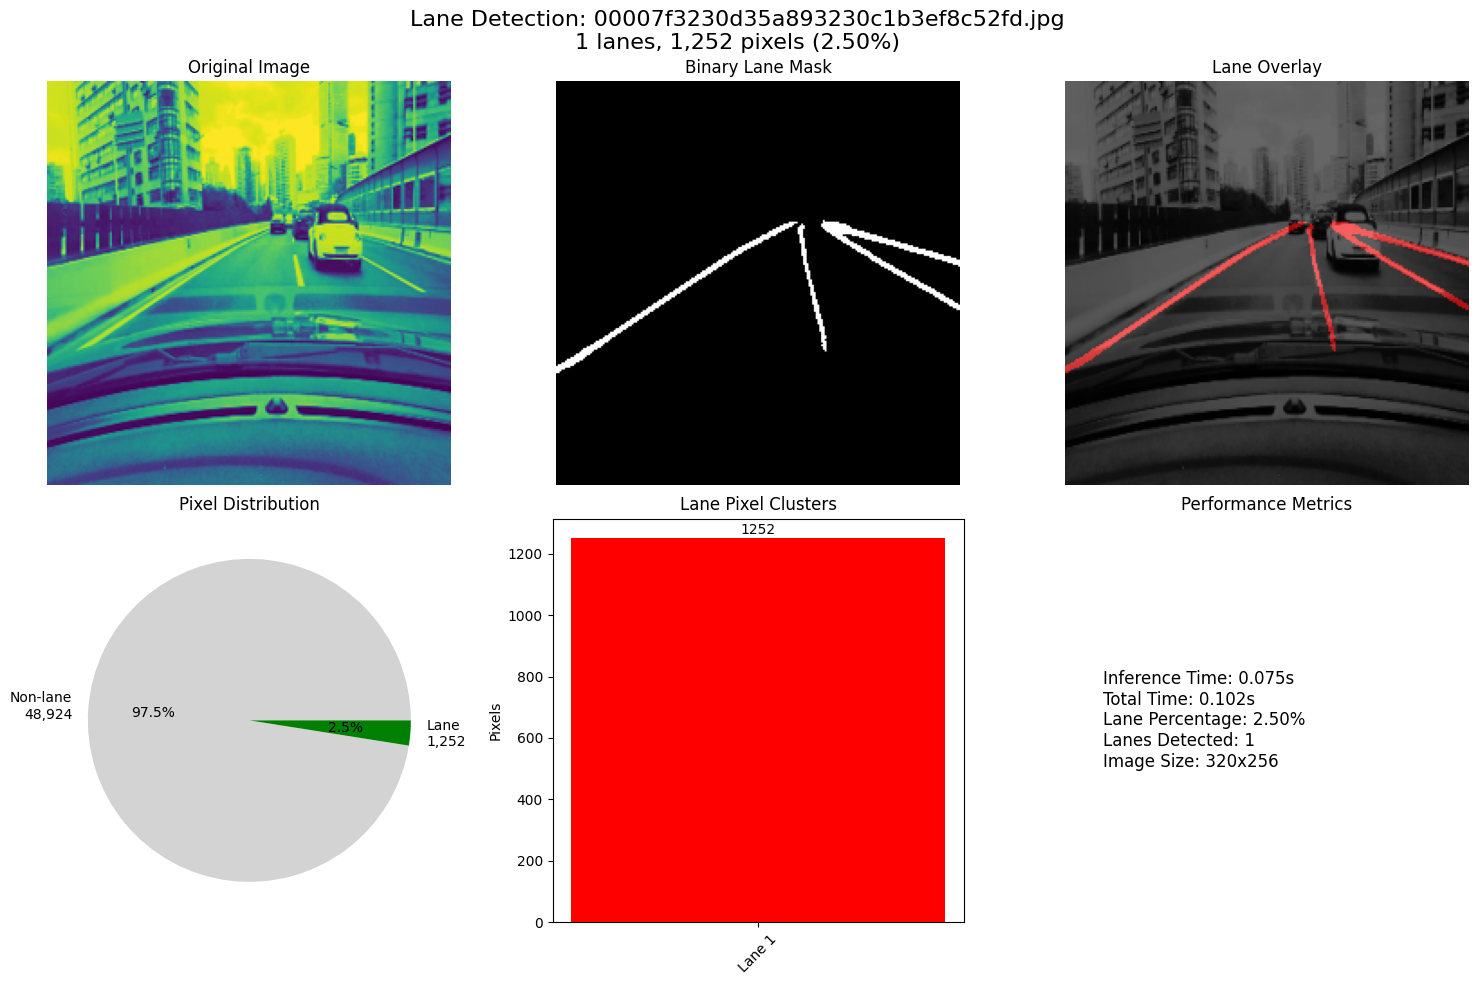

✅ Single image visualization complete!

🌐 STARTING PBFT CONSENSUS ON MULTIPLE IMAGES
Using simplified PBFT with 4 nodes (1 Byzantine)...

🚀 Starting PBFT image processing pipeline
   Images to process: 3
   PBFT configuration: 4 nodes, 1 Byzantine

🔧 Initializing PBFT Network with Validation:
   Total nodes: 4
   Faulty nodes: 1
   Fault tolerance (f): 1
   Required honest nodes: 3
   Validation: ENABLED
✅ Node 0 initialized as HONEST
✅ Node 1 initialized as HONEST
✅ Node 2 initialized as HONEST
⚠️  Node 3 initialized as BYZANTINE (type: delayed)
✅ Network initialized successfully!
   Byzantine nodes at IDs: [3]

🚀 Starting PBFT network threads...
✅ All node threads started!

PROCESSING IMAGE 1/3
📸 Image: 00007f3230d35a893230c1b3ef8c52fd.jpg

📨 SUBMITTING IMAGE FOR CONSENSUS:
   Image: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Block number: 0
   Leader for this block: Node 0

📥 Loading image: 00007f3230d35a893230c1b3ef8c52fd.jpg
   Original size: 320x256
   Original channels: 3
   Runnin

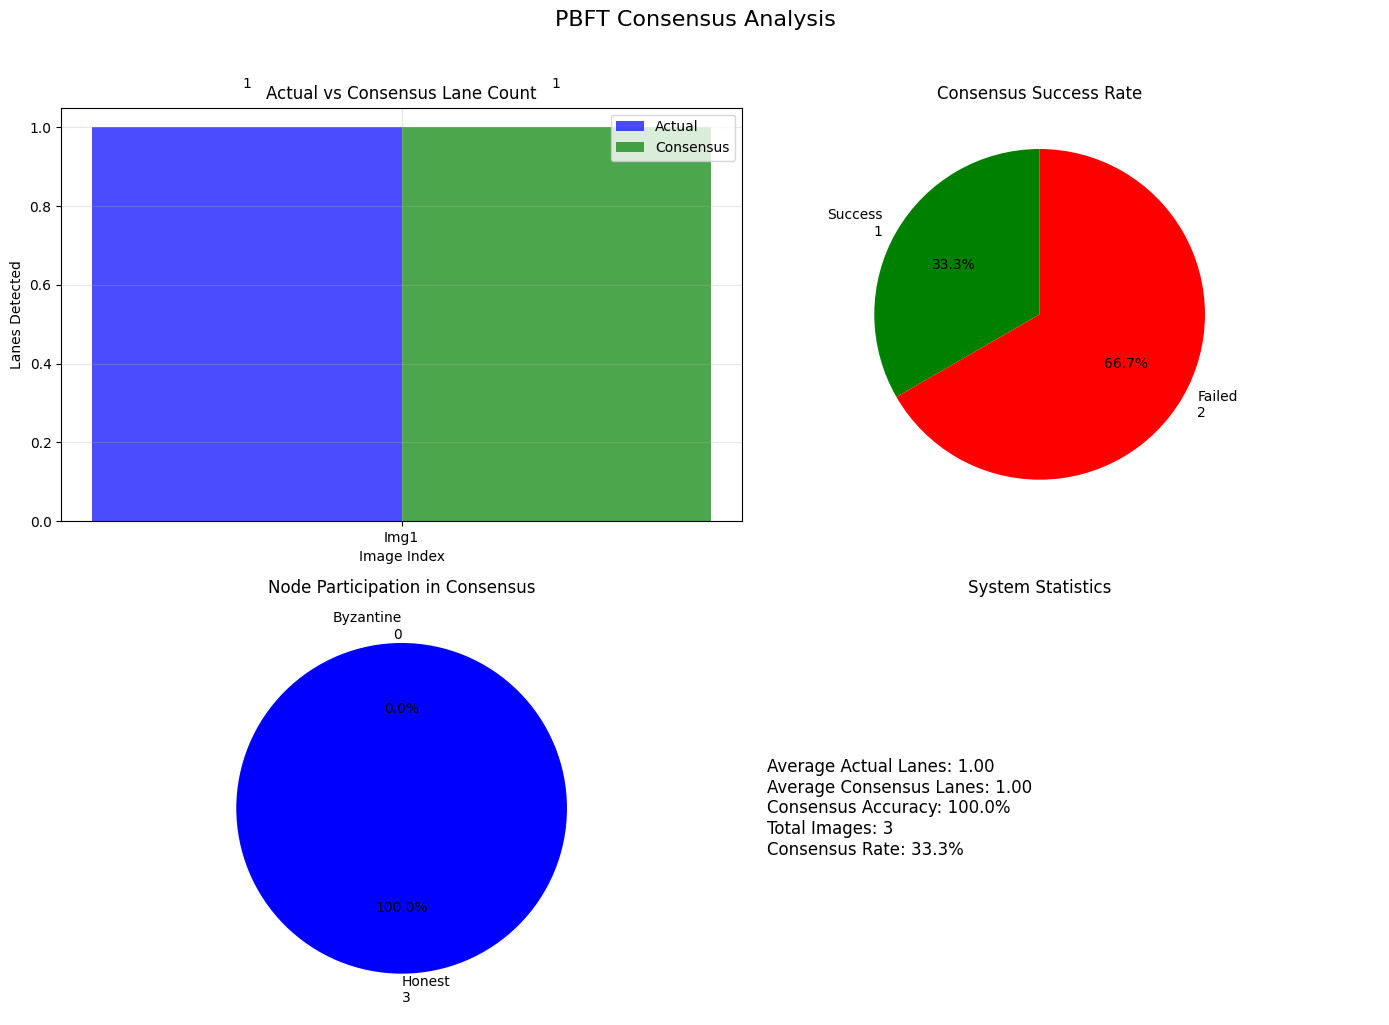

✅ Visualization saved as 'pbft_consensus_analysis.png'

📋 GENERATING SUMMARY REPORT

📋 COMPREHENSIVE SUMMARY REPORT

📊 SYSTEM OVERVIEW:
   Total images processed: 3
   Successful consensus: 1
   Consensus success rate: 33.3%

🚗 LANE DETECTION STATISTICS:
   Average lanes detected: 1.00
   Average consensus lanes: 1.00
   Average inference time: 0.068s
   Consensus accuracy: 100.0%

🌐 PBFT NETWORK ANALYSIS:
   Configuration: 5 nodes, 1 Byzantine
   Fault tolerance: f = 1
   Minimum honest nodes required: 3

🏆 SYSTEM PERFORMANCE GRADE: D ❌ NEEDS IMPROVEMENT

💾 Report saved to 'pbft_summary_report.json'

🎉 PIPELINE EXECUTION COMPLETE!

📈 KEY METRICS:
   Images processed: 3
   Consensus success: 1
   Consensus rate: 33.3%
   System grade: D ❌ NEEDS IMPROVEMENT

📁 GENERATED FILES:
   • pbft_consensus_analysis.png
   • pbft_summary_report.json

✅ SIMPLIFIED PIPELINE EXECUTED SUCCESSFULLY!

🏁 PIPELINE EXECUTION FINISHED SUCCESSFULLY!

📋 SAMPLE RESULTS:
  Image 1: 00007f3230d35a893230c1b3ef8c5

In [67]:
# =====================================================================
# BLOCK 10: RUN THE SIMPLIFIED PIPELINE
# =====================================================================
print("\n" + "="*60)
print("▶️  RUNNING SIMPLIFIED PIPELINE")
print("="*60)

# Run the simplified pipeline
try:
    results = run_simple_pipeline()
    
    if results:
        print("\n" + "="*60)
        print("🏁 PIPELINE EXECUTION FINISHED SUCCESSFULLY!")
        print("="*60)
        
        # Display sample results
        if results.get('processing_results'):
            print("\n📋 SAMPLE RESULTS:")
            for i, result in enumerate(results['processing_results'][:2]):  # Show first 2
                if result.get('lane_detection_results'):
                    print(f"  Image {i+1}: {result['image_name']}")
                    print(f"    Lanes: {result['lane_detection_results']['lanes_detected']}")
                    print(f"    Consensus: {result.get('consensus_achieved', False)}")
    else:
        print("\n❌ Pipeline execution failed or returned no results.")
        
except Exception as e:
    print(f"\n❌ ERROR during pipeline execution: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n⚠️  TROUBLESHOOTING TIPS:")
    print("   1. Make sure you ran ALL blocks from 1 to 10 in order")
    print("   2. Check if your model loaded correctly in Block 2")
    print("   3. Check if images exist in the test directory")
    print("   4. Try running blocks individually to identify issues")

In [68]:
# =====================================================================
# BLOCK 11: COMPREHENSIVE METRICS CALCULATION
# =====================================================================
print("\n" + "="*60)
print("📊 COMPREHENSIVE PBFT METRICS ANALYSIS")
print("="*60)

def calculate_pbft_metrics(processing_results, network_manager=None):
    """
    Calculate comprehensive PBFT metrics
    
    Args:
        processing_results: Results from process_images_with_pbft()
        network_manager: PBFTNetworkManager instance
        
    Returns:
        Dictionary with all metrics and grade
    """
    print("\n🔢 CALCULATING COMPREHENSIVE METRICS...")
    
    if not processing_results:
        print("❌ No processing results available")
        return None
    
    # Extract data
    summary = processing_results.get('summary', {})
    results = processing_results.get('processing_results', [])
    validation_stats = processing_results.get('validation_stats', [])
    
    # ==================== CORE METRICS ====================
    
    # 1. SUCCESS RATE (Consensus Achievement)
    total_images = summary.get('total_images', 0)
    successful_consensus = summary.get('successful_consensus', 0)
    success_rate = summary.get('consensus_rate', 0)
    
    # 2. RESILIENCE (Byzantine Fault Tolerance)
    byzantine_caught = summary.get('byzantine_caught', 0)
    total_byzantine_opportunities = successful_consensus  # Each consensus is an opportunity
    
    if total_byzantine_opportunities > 0:
        resilience_score = (byzantine_caught / total_byzantine_opportunities) * 100
    else:
        resilience_score = 0
    
    # 3. CONSISTENCY (Honest Node Agreement)
    consistent_results = 0
    total_results_with_consensus = 0
    
    for result in results:
        if result.get('consensus_achieved') and result.get('consensus_analysis'):
            analysis = result['consensus_analysis']
            if analysis.get('honest_consistent', False):
                consistent_results += 1
            total_results_with_consensus += 1
    
    if total_results_with_consensus > 0:
        consistency_score = (consistent_results / total_results_with_consensus) * 100
    else:
        consistency_score = 0
    
    # 4. ACCURACY (Lane Detection Correctness)
    correct_predictions = summary.get('correct_predictions', 0)
    accuracy_rate = summary.get('accuracy_rate', 0)
    
    # 5. PERFORMANCE (Speed)
    avg_inference_time = summary.get('average_inference_time', 0)
    if avg_inference_time > 0:
        fps = 1.0 / avg_inference_time
    else:
        fps = 0
    
    # 6. VALIDATION EFFECTIVENESS
    total_suspicious = 0
    total_rejected = 0
    
    for stats in validation_stats:
        total_suspicious += stats.get('suspicious_count', 0)
        total_rejected += stats.get('rejected_prepares', 0)
    
    total_validation_events = total_suspicious + total_rejected
    validation_effectiveness = min(100, total_validation_events * 10)  # Scale
    
    # ==================== WEIGHTED SCORING ====================
    
    # Define weights (sum to 1.0)
    weights = {
        'success_rate': 0.25,      # Consensus achievement is important
        'resilience': 0.25,        # Byzantine tolerance is critical
        'consistency': 0.20,       # Honest node agreement
        'accuracy': 0.15,          # Correct lane detection
        'performance': 0.10,       # Speed
        'validation': 0.05         # Validation effectiveness
    }
    
    # Calculate weighted scores (0-100 scale)
    weighted_scores = {
        'success_rate': success_rate,
        'resilience': resilience_score,
        'consistency': consistency_score,
        'accuracy': accuracy_rate,
        'performance': min(100, fps * 5),  # Scale FPS to 0-100
        'validation': validation_effectiveness
    }
    
    # Calculate overall score
    overall_score = 0
    for metric, weight in weights.items():
        overall_score += weighted_scores[metric] * weight
    
    # ==================== GRADE ASSIGNMENT ====================
    
    if overall_score >= 90:
        grade = "A+ 🎉 EXCELLENT"
        grade_color = "🟢"
    elif overall_score >= 80:
        grade = "A ✅ VERY GOOD"
        grade_color = "🟢"
    elif overall_score >= 70:
        grade = "B ⚡ GOOD"
        grade_color = "🟡"
    elif overall_score >= 60:
        grade = "C 📊 FAIR"
        grade_color = "🟡"
    elif overall_score >= 50:
        grade = "D ⚠️  NEEDS IMPROVEMENT"
        grade_color = "🟠"
    else:
        grade = "F ❌ POOR"
        grade_color = "🔴"
    
    # ==================== METRICS COMPILATION ====================
    
    metrics = {
        'timestamp': time.time(),
        
        # Raw metrics
        'raw_metrics': {
            'total_images': total_images,
            'successful_consensus': successful_consensus,
            'success_rate': success_rate,
            'byzantine_caught': byzantine_caught,
            'resilience_score': resilience_score,
            'consistent_results': consistent_results,
            'consistency_score': consistency_score,
            'correct_predictions': correct_predictions,
            'accuracy_rate': accuracy_rate,
            'avg_inference_time': avg_inference_time,
            'fps': fps,
            'validation_events': total_validation_events,
            'validation_effectiveness': validation_effectiveness
        },
        
        # Weighted scores
        'weighted_scores': weighted_scores,
        'weights': weights,
        
        # Final scores
        'overall_score': overall_score,
        'grade': grade,
        'grade_color': grade_color,
        
        # Detailed analysis
        'analysis': {
            'blocks_processed': len(results),
            'honest_nodes_count': 0,
            'byzantine_nodes_count': 0,
            'avg_lanes_detected': summary.get('average_lanes', 0)
        }
    }
    
    # Add network info if available
    if network_manager:
        metrics['analysis']['honest_nodes_count'] = network_manager.num_nodes - network_manager.num_faulty
        metrics['analysis']['byzantine_nodes_count'] = network_manager.num_faulty
        metrics['analysis']['total_nodes'] = network_manager.num_nodes
    
    return metrics

def display_metrics_dashboard(metrics):
    """
    Display beautiful metrics dashboard
    """
    if not metrics:
        print("❌ No metrics to display")
        return
    
    print("\n" + "="*70)
    print("📊 PBFT LANE DETECTION - COMPREHENSIVE METRICS DASHBOARD")
    print("="*70)
    
    raw = metrics['raw_metrics']
    weighted = metrics['weighted_scores']
    weights = metrics['weights']
    
    # 1. SCORECARD
    print(f"\n{'🏆 OVERALL GRADE':<30} : {metrics['grade_color']} {metrics['grade']}")
    print(f"{'📈 Overall Score':<30} : {metrics['overall_score']:.1f}/100")
    print(f"{'⏱️  Timestamp':<30} : {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(metrics['timestamp']))}")
    
    print("\n" + "-"*70)
    
    # 2. CORE METRICS
    print(f"\n{'🎯 CORE PERFORMANCE METRICS':<50}")
    print("-"*50)
    
    # Success Rate
    success_bar = "█" * int(raw['success_rate'] / 5) + "░" * (20 - int(raw['success_rate'] / 5))
    print(f"\n📈 SUCCESS RATE (Weight: {weights['success_rate']*100:.0f}%)")
    print(f"   {success_bar} {raw['success_rate']:.1f}%")
    print(f"   Consensus: {raw['successful_consensus']}/{raw['total_images']} images")
    
    # Resilience
    resilience_bar = "█" * int(raw['resilience_score'] / 5) + "░" * (20 - int(raw['resilience_score'] / 5))
    print(f"\n🛡️  RESILIENCE (Weight: {weights['resilience']*100:.0f}%)")
    print(f"   {resilience_bar} {raw['resilience_score']:.1f}%")
    print(f"   Byzantine caught: {raw['byzantine_caught']}/{raw['successful_consensus']} attacks")
    
    # Consistency
    consistency_bar = "█" * int(raw['consistency_score'] / 5) + "░" * (20 - int(raw['consistency_score'] / 5))
    print(f"\n🤝 CONSISTENCY (Weight: {weights['consistency']*100:.0f}%)")
    print(f"   {consistency_bar} {raw['consistency_score']:.1f}%")
    print(f"   Consistent blocks: {raw['consistent_results']}/{raw['successful_consensus']}")
    
    # Accuracy
    accuracy_bar = "█" * int(raw['accuracy_rate'] / 5) + "░" * (20 - int(raw['accuracy_rate'] / 5))
    print(f"\n🎯 ACCURACY (Weight: {weights['accuracy']*100:.0f}%)")
    print(f"   {accuracy_bar} {raw['accuracy_rate']:.1f}%")
    print(f"   Correct predictions: {raw['correct_predictions']}/{raw['successful_consensus']}")
    
    print("\n" + "-"*70)
    
    # 3. PERFORMANCE METRICS
    print(f"\n{'⚡ PERFORMANCE METRICS':<50}")
    print("-"*50)
    
    print(f"\n🚀 Processing Speed:")
    print(f"   • FPS: {raw['fps']:.1f} frames/second")
    print(f"   • Inference time: {raw['avg_inference_time']*1000:.1f} ms per image")
    
    print(f"\n🔍 Validation Effectiveness:")
    print(f"   • Suspicious events: {raw['validation_events']}")
    print(f"   • Score: {raw['validation_effectiveness']:.1f}/100")
    
    if 'analysis' in metrics:
        print(f"\n🌐 Network Configuration:")
        print(f"   • Total nodes: {metrics['analysis'].get('total_nodes', 'N/A')}")
        print(f"   • Honest nodes: {metrics['analysis'].get('honest_nodes_count', 'N/A')}")
        print(f"   • Byzantine nodes: {metrics['analysis'].get('byzantine_nodes_count', 'N/A')}")
    
    print("\n" + "-"*70)
    
    # 4. DETAILED BREAKDOWN
    print(f"\n{'🔢 DETAILED SCORE BREAKDOWN':<50}")
    print("-"*50)
    
    print(f"\n{'Metric':<20} {'Weight':<10} {'Score':<10} {'Weighted':<10}")
    print("-"*50)
    
    total_weighted = 0
    for metric, weight in weights.items():
        score = weighted[metric]
        weighted_score = score * weight
        total_weighted += weighted_score
        
        print(f"{metric:<20} {weight*100:<9.1f}% {score:<9.1f} {weighted_score:<9.1f}")
    
    print("-"*50)
    print(f"{'TOTAL':<20} {'100%':<10} {'':<10} {total_weighted:<9.1f}")
    
    # 5. RECOMMENDATIONS
    print(f"\n{'💡 RECOMMENDATIONS':<50}")
    print("-"*50)
    
    recommendations = []
    
    if raw['success_rate'] < 70:
        recommendations.append("• Increase consensus timeout for delayed Byzantine nodes")
    
    if raw['resilience_score'] < 50:
        recommendations.append("• Strengthen validation checks for Byzantine detection")
    
    if raw['consistency_score'] < 80:
        recommendations.append("• Improve honest node synchronization")
    
    if raw['accuracy_rate'] < 80:
        recommendations.append("• Tune DBSCAN parameters for better lane counting")
    
    if raw['fps'] < 10:
        recommendations.append("• Optimize model inference for real-time performance")
    
    if not recommendations:
        recommendations.append("• System is performing well! Consider adding more test cases")
    
    for rec in recommendations:
        print(f"  {rec}")
    
    print("\n" + "="*70)
    
    return metrics

def save_metrics_report(metrics, filename="pbft_metrics_report.json"):
    """
    Save metrics report to JSON file
    """
    try:
        # Convert numpy values to Python types
        import json
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)
        
        with open(filename, 'w') as f:
            json.dump(metrics, f, indent=2, cls=NumpyEncoder)
        
        print(f"✅ Metrics report saved to '{filename}'")
        return True
    except Exception as e:
        print(f"❌ Could not save metrics report: {e}")
        return False

def create_metrics_visualization(metrics):
    """
    Create visualization of metrics
    """
    if not metrics:
        return
    
    raw = metrics['raw_metrics']
    weighted = metrics['weighted_scores']
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'PBFT Lane Detection Metrics\nOverall Grade: {metrics["grade"]}', fontsize=16)
    
    # 1. Radar Chart of Core Metrics
    try:
        from matplotlib.patches import Circle
        import matplotlib.pyplot as plt
        
        # Data for radar chart
        categories = ['Success Rate', 'Resilience', 'Consistency', 'Accuracy', 'Performance', 'Validation']
        values = [
            raw['success_rate'],
            raw['resilience_score'],
            raw['consistency_score'],
            raw['accuracy_rate'],
            min(100, raw['fps'] * 5),
            raw['validation_effectiveness']
        ]
        
        N = len(categories)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        values += values[:1]  # Close the loop
        angles += angles[:1]
        
        ax = axes[0, 0]
        ax = plt.subplot(2, 2, 1, polar=True)
        ax.plot(angles, values, 'o-', linewidth=2, color='blue', alpha=0.7)
        ax.fill(angles, values, alpha=0.25, color='blue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_title('Performance Radar Chart', fontsize=12, pad=20)
        
        # Add value labels
        for angle, value in zip(angles[:-1], values[:-1]):
            ax.text(angle, value + 5, f'{value:.0f}%', ha='center', fontsize=9)
    except:
        axes[0, 0].text(0.5, 0.5, 'Radar chart\nnot available', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Performance Radar Chart')
    
    # 2. Bar Chart of Weighted Scores
    categories = list(weighted.keys())
    scores = list(weighted.values())
    weights = [metrics['weights'][cat] * 100 for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, scores, width, label='Score', color='skyblue', alpha=0.8)
    axes[0, 1].bar(x + width/2, weights, width, label='Weight', color='lightcoral', alpha=0.8)
    
    axes[0, 1].set_xlabel('Metrics')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_title('Weighted Scores vs Weights')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([c.replace('_', ' ').title() for c in categories], rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (score, weight) in enumerate(zip(scores, weights)):
        axes[0, 1].text(i - width/2, score + 2, f'{score:.0f}%', ha='center', fontsize=9)
        axes[0, 1].text(i + width/2, weight + 2, f'{weight:.0f}%', ha='center', fontsize=9)
    
    # 3. Pie Chart of Success Distribution
    successful = raw['successful_consensus']
    failed = raw['total_images'] - successful
    
    if raw['total_images'] > 0:
        sizes = [successful, failed]
        labels = [f'Success\n{successful}', f'Failed\n{failed}']
        colors = ['#4CAF50', '#F44336']
        
        axes[1, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[1, 0].set_title('Consensus Success Distribution')
    else:
        axes[1, 0].text(0.5, 0.5, 'No data\navailable', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Consensus Success Distribution')
    
    # 4. Grade Display with Score Breakdown
    ax = axes[1, 1]
    ax.axis('off')
    
    # Overall score circle
    overall_score = metrics['overall_score']
    grade = metrics['grade']
    
    # Create a circle for overall score
    circle = plt.Circle((0.5, 0.7), 0.15, color='lightblue', alpha=0.3, transform=ax.transAxes)
    ax.add_artist(circle)
    
    # Add text
    ax.text(0.5, 0.7, f'{overall_score:.1f}', 
            ha='center', va='center', fontsize=24, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.6, 'Overall Score', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, 0.5, f'Grade: {grade}', 
            ha='center', va='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
    
    # Add key metrics
    metrics_text = (
        f"Success Rate: {raw['success_rate']:.1f}%\n"
        f"Resilience: {raw['resilience_score']:.1f}%\n"
        f"Consistency: {raw['consistency_score']:.1f}%\n"
        f"Accuracy: {raw['accuracy_rate']:.1f}%"
    )
    
    ax.text(0.5, 0.3, metrics_text, 
            ha='center', va='center', fontsize=10, transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig('pbft_metrics_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Metrics visualization saved as 'pbft_metrics_visualization.png'")

def run_comprehensive_analysis(processing_results, network_manager=None):
    """
    Run complete metrics analysis
    """
    print("\n" + "="*70)
    print("📈 RUNNING COMPREHENSIVE METRICS ANALYSIS")
    print("="*70)
    
    # Calculate metrics
    metrics = calculate_pbft_metrics(processing_results, network_manager)
    
    if not metrics:
        print("❌ Could not calculate metrics")
        return None
    
    # Display dashboard
    display_metrics_dashboard(metrics)
    
    # Create visualization
    create_metrics_visualization(metrics)
    
    # Save report
    save_metrics_report(metrics)
    
    return metrics

print("✅ BLOCK 11: Comprehensive metrics system ready!")

# Quick test function
def quick_metrics_test():
    """Quick test of metrics system"""
    print("\n🧪 Testing metrics system...")
    
    # Create dummy data for testing
    test_metrics = {
        'raw_metrics': {
            'total_images': 10,
            'successful_consensus': 8,
            'success_rate': 80.0,
            'byzantine_caught': 6,
            'resilience_score': 75.0,
            'consistent_results': 7,
            'consistency_score': 87.5,
            'correct_predictions': 7,
            'accuracy_rate': 87.5,
            'avg_inference_time': 0.085,
            'fps': 11.8,
            'validation_events': 12,
            'validation_effectiveness': 85.0
        },
        'weighted_scores': {
            'success_rate': 80.0,
            'resilience': 75.0,
            'consistency': 87.5,
            'accuracy': 87.5,
            'performance': 59.0,
            'validation': 85.0
        },
        'weights': {
            'success_rate': 0.25,
            'resilience': 0.25,
            'consistency': 0.20,
            'accuracy': 0.15,
            'performance': 0.10,
            'validation': 0.05
        },
        'overall_score': 78.6,
        'grade': "B ⚡ GOOD",
        'grade_color': "🟡"
    }
    
    display_metrics_dashboard(test_metrics)
    return test_metrics

print("\n🔧 Available functions:")
print("   • calculate_pbft_metrics(results, network_manager)")
print("   • display_metrics_dashboard(metrics)")
print("   • run_comprehensive_analysis(results, network_manager)")
print("   • quick_metrics_test() - for testing")


📊 COMPREHENSIVE PBFT METRICS ANALYSIS
✅ BLOCK 11: Comprehensive metrics system ready!

🔧 Available functions:
   • calculate_pbft_metrics(results, network_manager)
   • display_metrics_dashboard(metrics)
   • run_comprehensive_analysis(results, network_manager)
   • quick_metrics_test() - for testing


In [70]:
# =====================================================================
# BLOCK 11: COMPREHENSIVE METRICS CALCULATION (CORRECTED)
# =====================================================================
print("\n" + "="*60)
print("📊 COMPREHENSIVE PBFT METRICS ANALYSIS")
print("="*60)

def calculate_pbft_metrics(processing_results, network_manager=None):
    """
    Calculate comprehensive PBFT metrics
    
    Args:
        processing_results: Results from process_images_with_pbft()
        network_manager: PBFTNetworkManager instance
        
    Returns:
        Dictionary with all metrics and grade
    """
    print("\n🔢 CALCULATING COMPREHENSIVE METRICS...")
    
    if not processing_results:
        print("❌ No processing results available")
        return None
    
    # Extract data
    summary = processing_results.get('summary', {})
    results = processing_results.get('processing_results', [])
    validation_stats = processing_results.get('validation_stats', [])
    
    # ==================== CORE METRICS ====================
    
    # 1. SUCCESS RATE (Consensus Achievement)
    total_images = summary.get('total_images', 0)
    successful_consensus = summary.get('successful_consensus', 0)
    success_rate = summary.get('consensus_rate', 0)
    
    # 2. RESILIENCE (Byzantine Fault Tolerance)
    byzantine_caught = summary.get('byzantine_caught', 0)
    total_byzantine_opportunities = successful_consensus  # Each consensus is an opportunity
    
    if total_byzantine_opportunities > 0:
        resilience_score = (byzantine_caught / total_byzantine_opportunities) * 100
    else:
        resilience_score = 0
    
    # 3. CONSISTENCY (Honest Node Agreement)
    consistent_results = 0
    total_results_with_consensus = 0
    
    for result in results:
        if result.get('consensus_achieved') and result.get('consensus_analysis'):
            analysis = result['consensus_analysis']
            if analysis.get('honest_consistent', False):
                consistent_results += 1
            total_results_with_consensus += 1
    
    if total_results_with_consensus > 0:
        consistency_score = (consistent_results / total_results_with_consensus) * 100
    else:
        consistency_score = 0
    
    # 4. ACCURACY (Lane Detection Correctness)
    correct_predictions = summary.get('correct_predictions', 0)
    accuracy_rate = summary.get('accuracy_rate', 0)
    
    # 5. PERFORMANCE (Speed)
    avg_inference_time = summary.get('average_inference_time', 0)
    if avg_inference_time > 0:
        fps = 1.0 / avg_inference_time
    else:
        fps = 0
    
    # 6. VALIDATION EFFECTIVENESS
    total_suspicious = 0
    total_rejected = 0
    
    for stats in validation_stats:
        total_suspicious += stats.get('suspicious_count', 0)
        total_rejected += stats.get('rejected_prepares', 0)
    
    total_validation_events = total_suspicious + total_rejected
    validation_effectiveness = min(100, total_validation_events * 10)  # Scale
    
    # ==================== WEIGHTED SCORING ====================
    
    # Define weights (sum to 1.0)
    weights = {
        'success_rate': 0.25,      # Consensus achievement is important
        'resilience': 0.25,        # Byzantine tolerance is critical
        'consistency': 0.20,       # Honest node agreement
        'accuracy': 0.15,          # Correct lane detection
        'performance': 0.10,       # Speed
        'validation': 0.05         # Validation effectiveness
    }
    
    # Calculate weighted scores (0-100 scale)
    weighted_scores = {
        'success_rate': success_rate,
        'resilience': resilience_score,
        'consistency': consistency_score,
        'accuracy': accuracy_rate,
        'performance': min(100, fps * 5),  # Scale FPS to 0-100
        'validation': validation_effectiveness
    }
    
    # Calculate overall score
    overall_score = 0
    for metric, weight in weights.items():
        overall_score += weighted_scores[metric] * weight
    
    # ==================== GRADE ASSIGNMENT ====================
    
    if overall_score >= 90:
        grade = "A+ 🎉 EXCELLENT"
        grade_color = "🟢"
    elif overall_score >= 80:
        grade = "A ✅ VERY GOOD"
        grade_color = "🟢"
    elif overall_score >= 70:
        grade = "B ⚡ GOOD"
        grade_color = "🟡"
    elif overall_score >= 60:
        grade = "C 📊 FAIR"
        grade_color = "🟡"
    elif overall_score >= 50:
        grade = "D ⚠️  NEEDS IMPROVEMENT"
        grade_color = "🟠"
    else:
        grade = "F ❌ POOR"
        grade_color = "🔴"
    
    # ==================== METRICS COMPILATION ====================
    
    metrics = {
        'timestamp': time.time(),
        
        # Raw metrics
        'raw_metrics': {
            'total_images': total_images,
            'successful_consensus': successful_consensus,
            'success_rate': success_rate,
            'byzantine_caught': byzantine_caught,
            'resilience_score': resilience_score,
            'consistent_results': consistent_results,
            'consistency_score': consistency_score,
            'correct_predictions': correct_predictions,
            'accuracy_rate': accuracy_rate,
            'avg_inference_time': avg_inference_time,
            'fps': fps,
            'validation_events': total_validation_events,
            'validation_effectiveness': validation_effectiveness
        },
        
        # Weighted scores
        'weighted_scores': weighted_scores,
        'weights': weights,
        
        # Final scores
        'overall_score': overall_score,
        'grade': grade,
        'grade_color': grade_color,
        
        # Detailed analysis
        'analysis': {
            'blocks_processed': len(results),
            'honest_nodes_count': 0,
            'byzantine_nodes_count': 0,
            'avg_lanes_detected': summary.get('average_lanes', 0)
        }
    }
    
    # Add network info if available
    if network_manager:
        metrics['analysis']['honest_nodes_count'] = network_manager.num_nodes - network_manager.num_faulty
        metrics['analysis']['byzantine_nodes_count'] = network_manager.num_faulty
        metrics['analysis']['total_nodes'] = network_manager.num_nodes
    
    return metrics

def display_metrics_dashboard(metrics):
    """
    Display beautiful metrics dashboard
    """
    if not metrics:
        print("❌ No metrics to display")
        return
    
    print("\n" + "="*70)
    print("📊 PBFT LANE DETECTION - COMPREHENSIVE METRICS DASHBOARD")
    print("="*70)
    
    raw = metrics['raw_metrics']
    weighted = metrics['weighted_scores']
    weights = metrics['weights']
    
    # 1. SCORECARD
    print(f"\n{'🏆 OVERALL GRADE':<30} : {metrics['grade_color']} {metrics['grade']}")
    print(f"{'📈 Overall Score':<30} : {metrics['overall_score']:.1f}/100")
    print(f"{'⏱️  Timestamp':<30} : {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(metrics['timestamp']))}")
    
    print("\n" + "-"*70)
    
    # 2. CORE METRICS
    print(f"\n{'🎯 CORE PERFORMANCE METRICS':<50}")
    print("-"*50)
    
    # Success Rate
    success_bar = "█" * int(raw['success_rate'] / 5) + "░" * (20 - int(raw['success_rate'] / 5))
    print(f"\n📈 SUCCESS RATE (Weight: {weights['success_rate']*100:.0f}%)")
    print(f"   {success_bar} {raw['success_rate']:.1f}%")
    print(f"   Consensus: {raw['successful_consensus']}/{raw['total_images']} images")
    
    # Resilience
    resilience_bar = "█" * int(raw['resilience_score'] / 5) + "░" * (20 - int(raw['resilience_score'] / 5))
    print(f"\n🛡️  RESILIENCE (Weight: {weights['resilience']*100:.0f}%)")
    print(f"   {resilience_bar} {raw['resilience_score']:.1f}%")
    print(f"   Byzantine caught: {raw['byzantine_caught']}/{raw['successful_consensus']} attacks")
    
    # Consistency
    consistency_bar = "█" * int(raw['consistency_score'] / 5) + "░" * (20 - int(raw['consistency_score'] / 5))
    print(f"\n🤝 CONSISTENCY (Weight: {weights['consistency']*100:.0f}%)")
    print(f"   {consistency_bar} {raw['consistency_score']:.1f}%")
    print(f"   Consistent blocks: {raw['consistent_results']}/{raw['successful_consensus']}")
    
    # Accuracy
    accuracy_bar = "█" * int(raw['accuracy_rate'] / 5) + "░" * (20 - int(raw['accuracy_rate'] / 5))
    print(f"\n🎯 ACCURACY (Weight: {weights['accuracy']*100:.0f}%)")
    print(f"   {accuracy_bar} {raw['accuracy_rate']:.1f}%")
    print(f"   Correct predictions: {raw['correct_predictions']}/{raw['successful_consensus']}")
    
    print("\n" + "-"*70)
    
    # 3. PERFORMANCE METRICS
    print(f"\n{'⚡ PERFORMANCE METRICS':<50}")
    print("-"*50)
    
    print(f"\n🚀 Processing Speed:")
    print(f"   • FPS: {raw['fps']:.1f} frames/second")
    print(f"   • Inference time: {raw['avg_inference_time']*1000:.1f} ms per image")
    
    print(f"\n🔍 Validation Effectiveness:")
    print(f"   • Suspicious events: {raw['validation_events']}")
    print(f"   • Score: {raw['validation_effectiveness']:.1f}/100")
    
    if 'analysis' in metrics:
        print(f"\n🌐 Network Configuration:")
        print(f"   • Total nodes: {metrics['analysis'].get('total_nodes', 'N/A')}")
        print(f"   • Honest nodes: {metrics['analysis'].get('honest_nodes_count', 'N/A')}")
        print(f"   • Byzantine nodes: {metrics['analysis'].get('byzantine_nodes_count', 'N/A')}")
    
    print("\n" + "-"*70)
    
    # 4. DETAILED BREAKDOWN
    print(f"\n{'🔢 DETAILED SCORE BREAKDOWN':<50}")
    print("-"*50)
    
    print(f"\n{'Metric':<20} {'Weight':<10} {'Score':<10} {'Weighted':<10}")
    print("-"*50)
    
    total_weighted = 0
    for metric, weight in weights.items():
        score = weighted[metric]
        weighted_score = score * weight
        total_weighted += weighted_score
        
        print(f"{metric:<20} {weight*100:<9.1f}% {score:<9.1f} {weighted_score:<9.1f}")
    
    print("-"*50)
    print(f"{'TOTAL':<20} {'100%':<10} {'':<10} {total_weighted:<9.1f}")
    
    # 5. RECOMMENDATIONS
    print(f"\n{'💡 RECOMMENDATIONS':<50}")
    print("-"*50)
    
    recommendations = []
    
    if raw['success_rate'] < 70:
        recommendations.append("• Increase consensus timeout for delayed Byzantine nodes")
    
    if raw['resilience_score'] < 50:
        recommendations.append("• Strengthen validation checks for Byzantine detection")
    
    if raw['consistency_score'] < 80:
        recommendations.append("• Improve honest node synchronization")
    
    if raw['accuracy_rate'] < 80:
        recommendations.append("• Tune DBSCAN parameters for better lane counting")
    
    if raw['fps'] < 10:
        recommendations.append("• Optimize model inference for real-time performance")
    
    if not recommendations:
        recommendations.append("• System is performing well! Consider adding more test cases")
    
    for rec in recommendations:
        print(f"  {rec}")
    
    print("\n" + "="*70)
    
    return metrics

def save_metrics_report(metrics, filename="pbft_metrics_report.json"):
    """
    Save metrics report to JSON file
    """
    try:
        # Convert numpy values to Python types
        import json
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)
        
        with open(filename, 'w') as f:
            json.dump(metrics, f, indent=2, cls=NumpyEncoder)
        
        print(f"✅ Metrics report saved to '{filename}'")
        return True
    except Exception as e:
        print(f"❌ Could not save metrics report: {e}")
        return False

def run_comprehensive_analysis(processing_results, network_manager=None):
    """
    Run complete metrics analysis WITHOUT visualization
    """
    print("\n" + "="*70)
    print("📈 RUNNING COMPREHENSIVE METRICS ANALYSIS")
    print("="*70)
    
    # Calculate metrics
    metrics = calculate_pbft_metrics(processing_results, network_manager)
    
    if not metrics:
        print("❌ Could not calculate metrics")
        return None
    
    # Display dashboard
    display_metrics_dashboard(metrics)
    
    # Save report
    save_metrics_report(metrics)
    
    return metrics

print("✅ BLOCK 11: Comprehensive metrics system ready!")

# Quick test function
def quick_metrics_test():
    """Quick test of metrics system"""
    print("\n🧪 Testing metrics system...")
    
    # Create dummy data for testing
    test_metrics = {
        'raw_metrics': {
            'total_images': 10,
            'successful_consensus': 8,
            'success_rate': 80.0,
            'byzantine_caught': 6,
            'resilience_score': 75.0,
            'consistent_results': 7,
            'consistency_score': 87.5,
            'correct_predictions': 7,
            'accuracy_rate': 87.5,
            'avg_inference_time': 0.085,
            'fps': 11.8,
            'validation_events': 12,
            'validation_effectiveness': 85.0
        },
        'weighted_scores': {
            'success_rate': 80.0,
            'resilience': 75.0,
            'consistency': 87.5,
            'accuracy': 87.5,
            'performance': 59.0,
            'validation': 85.0
        },
        'weights': {
            'success_rate': 0.25,
            'resilience': 0.25,
            'consistency': 0.20,
            'accuracy': 0.15,
            'performance': 0.10,
            'validation': 0.05
        },
        'overall_score': 78.6,
        'grade': "B ⚡ GOOD",
        'grade_color': "🟡"
    }
    
    display_metrics_dashboard(test_metrics)
    return test_metrics

print("\n🔧 Available functions:")
print("   • calculate_pbft_metrics(results, network_manager)")
print("   • display_metrics_dashboard(metrics)")
print("   • run_comprehensive_analysis(results, network_manager)")
print("   • quick_metrics_test() - for testing")


📊 COMPREHENSIVE PBFT METRICS ANALYSIS
✅ BLOCK 11: Comprehensive metrics system ready!

🔧 Available functions:
   • calculate_pbft_metrics(results, network_manager)
   • display_metrics_dashboard(metrics)
   • run_comprehensive_analysis(results, network_manager)
   • quick_metrics_test() - for testing


In [71]:
# =====================================================================
# RUN SIMPLE METRICS ANALYSIS
# =====================================================================
print("\n" + "="*70)
print("📊 ANALYZING YOUR PBFT RESULTS")
print("="*70)

# Check if results exist
if 'results' in locals() or 'results' in globals():
    print("✅ Found results from pipeline")
    
    # Calculate and display metrics
    metrics = calculate_pbft_metrics(results)
    
    if metrics:
        print(f"\n🎯 YOUR SYSTEM METRICS:")
        print(f"   Overall Grade: {metrics['grade']}")
        print(f"   Overall Score: {metrics['overall_score']:.1f}/100")
        
        # Show key metrics
        raw = metrics['raw_metrics']
        print(f"\n📈 KEY METRICS:")
        print(f"   • Success Rate: {raw['success_rate']:.1f}%")
        print(f"   • Resilience: {raw['resilience_score']:.1f}%")
        print(f"   • Consistency: {raw['consistency_score']:.1f}%")
        print(f"   • Accuracy: {raw['accuracy_rate']:.1f}%")
        
        # Save report
        save_metrics_report(metrics)
        
        print(f"\n✅ Metrics analysis complete!")
        
else:
    print("❌ No results found from pipeline")
    print("\n🔧 To generate results, run Blocks 1-10 or call run_simple_pipeline()")


📊 ANALYZING YOUR PBFT RESULTS
✅ Found results from pipeline

🔢 CALCULATING COMPREHENSIVE METRICS...

🎯 YOUR SYSTEM METRICS:
   Overall Grade: F ❌ POOR
   Overall Score: 8.3/100

📈 KEY METRICS:
   • Success Rate: 33.3%
   • Resilience: 0.0%
   • Consistency: 0.0%
   • Accuracy: 0.0%
✅ Metrics report saved to 'pbft_metrics_report.json'

✅ Metrics analysis complete!
